!pip install ale-py

In [9]:
import gymnasium as gym
atari_ids = [e for e in gym.registry if e.startswith("ALE/")]
print(len(atari_ids), "Atari envs installed")   # e.g. 74


104 Atari envs installed


State dim: 3, Action dim: 1, Max action: 2.0
Episode 0: Reward=-1071.93, Steps=200
Episode 10: Reward=-1558.75, Steps=200
Episode 20: Reward=-863.79, Steps=200
Step 5000: Evaluation over 10 episodes: -1560.43
Episode 30: Reward=-976.03, Steps=200
Episode 40: Reward=-966.36, Steps=200
Step 10000: Evaluation over 10 episodes: -1399.50
Episode 50: Reward=-755.22, Steps=200
Episode 60: Reward=-995.98, Steps=200
Episode 70: Reward=-3.96, Steps=200
Step 15000: Evaluation over 10 episodes: -546.46
Episode 80: Reward=-1104.33, Steps=200
Episode 90: Reward=-246.28, Steps=200
Step 20000: Evaluation over 10 episodes: -143.26
Episode 100: Reward=-120.56, Steps=200
Episode 110: Reward=-259.46, Steps=200
Episode 120: Reward=-122.40, Steps=200
Step 25000: Evaluation over 10 episodes: -143.30
Episode 130: Reward=-118.47, Steps=200
Episode 140: Reward=-0.98, Steps=200
Step 30000: Evaluation over 10 episodes: -209.17
Episode 150: Reward=-230.52, Steps=200
Episode 160: Reward=-3.52, Steps=200
Episode 170

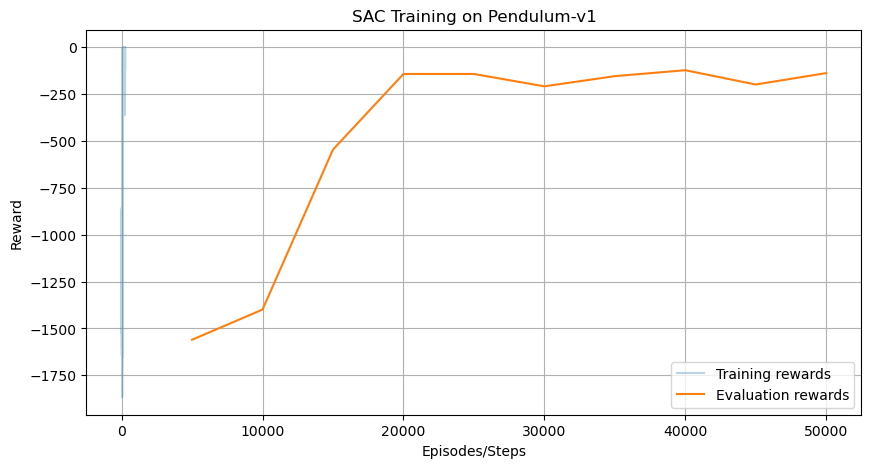

In [ ]:
import gymnasium as gym
import numpy as np
import torch
import time
import matplotlib.pyplot as plt

# # main idea is from https://github.com/DLR-RM/stable-baselines3/blob/master/stable_baselines3/sac/sac.py
class Actor(torch.nn.Module):
    def __init__(self, state_dim, action_dim, max_action, hidden_dim=256):
        super(Actor, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(state_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU()
        )
        self.mean = torch.nn.Linear(hidden_dim, action_dim)
        self.log_std = torch.nn.Linear(hidden_dim, action_dim)
        self.max_action = max_action

    def forward(self, state):
        features = self.net(state)
        mean = self.mean(features)
        log_std = self.log_std(features).clamp(-20, 2)
        std = torch.exp(log_std)

        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()
        raw_tanh = torch.tanh(x_t)
        action = raw_tanh * self.max_action

        # Correct jacobian for tanh + scaling
        log_prob = normal.log_prob(x_t)
        # Sum log probs over action dims
        log_prob = log_prob.sum(dim=1, keepdim=True)
        # Subtract log(abs(det(daction/dx_t)))
        log_prob -= torch.log(self.max_action * (1 - raw_tanh.pow(2)) + 1e-6).sum(dim=1, keepdim=True)

        return action, log_prob

# Q-value function approximator
class Critic(torch.nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Critic, self).__init__()
        self.q1 = torch.nn.Sequential(
            torch.nn.Linear(state_dim + action_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )
        self.q2 = torch.nn.Sequential(
            torch.nn.Linear(state_dim + action_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )

    def forward(self, state, action):
        sa = torch.cat([state, action], 1)
        return self.q1(sa), self.q2(sa)

# replay bbuffer function
class ReplayBuffer:
    def __init__(self, state_dim, action_dim, max_size=1e6):
        self.max_size = int(max_size)
        self.ptr = 0
        self.size = 0
        self.state = np.zeros((self.max_size, state_dim))
        self.action = np.zeros((self.max_size, action_dim))
        self.next_state = np.zeros((self.max_size, state_dim))
        self.reward = np.zeros((self.max_size, 1))
        self.done = np.zeros((self.max_size, 1))

    def add(self, state, action, next_state, reward, done):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.done[self.ptr] = float(done)
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, size=batch_size)
        return (
            torch.FloatTensor(self.state[ind]),
            torch.FloatTensor(self.action[ind]),
            torch.FloatTensor(self.next_state[ind]),
            torch.FloatTensor(self.reward[ind]),
            torch.FloatTensor(self.done[ind])
        )

# SAC Agent with gradient clipping and NaN checks
class SAC:
    def __init__(
        self, 
        state_dim,
        action_dim,
        max_action,
        discount=0.99,
        tau=0.005,
        policy_lr=3e-4,
        q_lr=3e-4,
        alpha_lr=3e-4,
        auto_entropy_tuning=True
    ):
        self.device = torch.device("cpu")
        self.actor = Actor(state_dim, action_dim, max_action).to(self.device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=policy_lr)
        self.critic = Critic(state_dim, action_dim).to(self.device)
        self.critic_target = Critic(state_dim, action_dim).to(self.device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=q_lr)
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        self.max_action = max_action
        self.discount = discount
        self.tau = tau
        self.auto_entropy_tuning = auto_entropy_tuning
        if self.auto_entropy_tuning:
            self.target_entropy = -action_dim
            self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
            self.alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=alpha_lr)
            self.alpha = self.log_alpha.exp()
        else:
            self.alpha = torch.tensor(0.2)

    def select_action(self, state, evaluate=False):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            if evaluate:
                features = self.actor.net(state)
                mean = self.actor.mean(features)
                action = torch.tanh(mean) * self.max_action
            else:
                action, _ = self.actor(state)
        return action.cpu().data.numpy().flatten()

    def train(self, replay_buffer, batch_size=256):
        state, action, next_state, reward, done = replay_buffer.sample(batch_size)
        state, action, next_state, reward, done = (
            state.to(self.device),
            action.to(self.device),
            next_state.to(self.device),
            reward.to(self.device),
            done.to(self.device)
        )
        # NaN checks
        assert not torch.isnan(state).any(), "state has NaNs!"
        assert not torch.isnan(action).any(), "action has NaNs!"
        assert not torch.isnan(next_state).any(), "next_state has NaNs!"
        with torch.no_grad():
            next_action, next_log_prob = self.actor(next_state)
            assert not torch.isnan(next_action).any(), "actor(next_state) gave NaNs!"
            assert not torch.isnan(next_log_prob).any(), "log_prob is NaN!"
            next_q1, next_q2 = self.critic_target(next_state, next_action)
            next_q = torch.min(next_q1, next_q2) - self.alpha * next_log_prob
            target_q = reward + (1 - done) * self.discount * next_q
        # critic update
        current_q1, current_q2 = self.critic(state, action)
        critic_loss = torch.nn.functional.mse_loss(current_q1, target_q) + \
                      torch.nn.functional.mse_loss(current_q2, target_q)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=1.0)
        self.critic_optimizer.step()
        # actor update
        action_new, log_prob = self.actor(state)
        q1_new, q2_new = self.critic(state, action_new)
        actor_loss = (self.alpha * log_prob - torch.min(q1_new, q2_new)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=1.0)
        self.actor_optimizer.step()
        # alpha update
        if self.auto_entropy_tuning:
            alpha_loss = -(self.log_alpha * (log_prob + self.target_entropy).detach()).mean()
            self.alpha_optimizer.zero_grad()
            alpha_loss.backward()
            self.alpha_optimizer.step()
            self.alpha = self.log_alpha.exp()
        
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1 - self.tau))
        return {"critic_loss": critic_loss.item(), "actor_loss": actor_loss.item(), "alpha": self.alpha.item()}

# Training f

def train_sac(env_name="Pendulum-v1", max_steps=100000, batch_size=256, eval_freq=5000, eval_episodes=10, print_freq=1000):
    env = gym.make(env_name)
    eval_env = gym.make(env_name)
    seed = 0
    torch.manual_seed(seed)
    np.random.seed(seed)
    env.action_space.seed(seed)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])
    print(f"State dim: {state_dim}, Action dim: {action_dim}, Max action: {max_action}")
    policy = SAC(state_dim, action_dim, max_action)
    replay_buffer = ReplayBuffer(state_dim, action_dim)
    episode_reward, episode_steps, episode_num = 0, 0, 0
    state, _ = env.reset(seed=seed)
    done = False
    train_rewards, eval_rewards, steps_list = [], [], []

    for t in range(1, max_steps + 1):
        if t < 10000:  # random exploration
            action = env.action_space.sample()
        else:
            action = policy.select_action(state)
        action_env = np.clip(action, env.action_space.low, env.action_space.high)
        next_state, reward, terminated, truncated, _ = env.step(action_env)
        done = terminated or truncated
        replay_buffer.add(state, action, next_state, reward, done)
        state = next_state
        episode_reward += reward
        episode_steps += 1
        if t >= 10000:
            policy.train(replay_buffer, batch_size)
        if done:
            train_rewards.append(episode_reward)
            if episode_num % 10 == 0:
                print(f"Episode {episode_num}: Reward={episode_reward:.2f}, Steps={episode_steps}")
            state, _ = env.reset()
            episode_reward, episode_steps = 0, 0
            episode_num += 1
            done = False
        if t % eval_freq == 0:
            eval_reward = evaluate_policy(policy, eval_env, eval_episodes)
            eval_rewards.append(eval_reward)
            steps_list.append(t)
            print(f"Step {t}: Evaluation over {eval_episodes} episodes: {eval_reward:.2f}")
    final_reward = evaluate_policy(policy, eval_env, eval_episodes)
    print(f"Final evaluation: {final_reward:.2f}")
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(train_rewards)), train_rewards, alpha=0.3, label='Training rewards')
    plt.plot(steps_list, eval_rewards, label='Evaluation rewards')
    plt.xlabel('Episodes/Steps')
    plt.ylabel('Reward')
    plt.title('SAC Training on Pendulum-v1')
    plt.legend()
    plt.grid(True)
    plt.show()
    return policy

# Eeva function

def evaluate_policy(policy, env, eval_episodes=10):
    avg_reward = 0.
    for _ in range(eval_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = policy.select_action(state, evaluate=True)
            action_env = np.clip(action, env.action_space.low, env.action_space.high)
            next_state, reward, terminated, truncated, _ = env.step(action_env)
            done = terminated or truncated
            avg_reward += reward
            state = next_state
    avg_reward /= eval_episodes
    return avg_reward


trained_policy = train_sac(max_steps=50000, eval_freq=5000)

# visualisation
def visualize_policy(policy, env_name="Pendulum-v1", episodes=3):
    env = gym.make(env_name, render_mode="human")
    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = policy.select_action(state, evaluate=True)
            action_env = np.clip(action, env.action_space.low, env.action_space.high)
            state, reward, terminated, truncated, _ = env.step(action_env)
            done = terminated or truncated
            total_reward += reward
            env.render()
            time.sleep(0.01)
        print(f"Visualization episode {ep+1}: Reward={total_reward:.2f}")
    env.close()


State dim: 3, Action dim: 1, Max action: 2.0
Episode 0: Reward=-1071.93, Steps=200
Episode 10: Reward=-1558.75, Steps=200
Episode 20: Reward=-863.79, Steps=200
Step 5000: Evaluation over 10 episodes: -1453.73
Episode 30: Reward=-976.03, Steps=200
Episode 40: Reward=-966.36, Steps=200
Step 10000: Evaluation over 10 episodes: -1303.47
Episode 50: Reward=-755.22, Steps=200
Episode 60: Reward=-995.98, Steps=200
Episode 70: Reward=-3.96, Steps=200
Step 15000: Evaluation over 10 episodes: -410.83
Episode 80: Reward=-1104.33, Steps=200
Episode 90: Reward=-246.28, Steps=200
Step 20000: Evaluation over 10 episodes: -177.31
Episode 100: Reward=-120.56, Steps=200
Episode 110: Reward=-259.46, Steps=200
Episode 120: Reward=-122.40, Steps=200
Step 25000: Evaluation over 10 episodes: -177.53
Episode 130: Reward=-118.47, Steps=200
Episode 140: Reward=-0.98, Steps=200
Step 30000: Evaluation over 10 episodes: -171.79
Episode 150: Reward=-230.52, Steps=200
Episode 160: Reward=-3.52, Steps=200
Episode 170

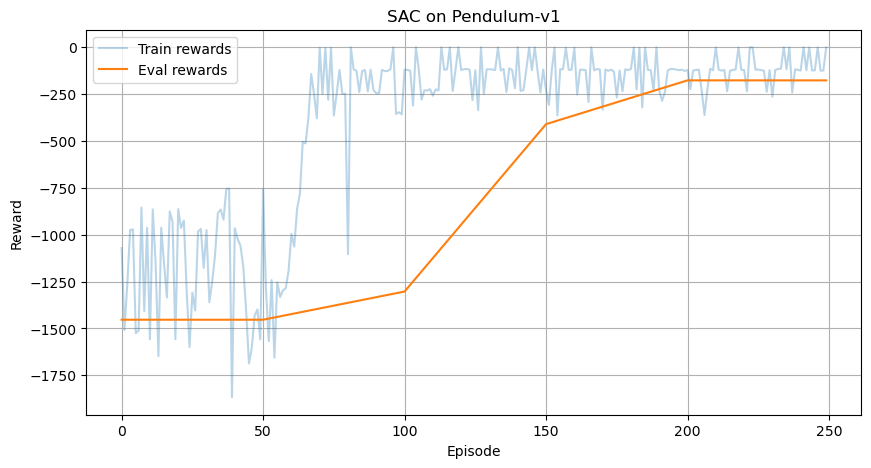

In [ ]:
import gymnasium as gym
import numpy as np
import torch
import time
import matplotlib.pyplot as plt

#baseline reward function

def summarize_returns(returns, name="Returns"):
    arr = np.array(returns)
    print(f"{name}: min={arr.min():.2f}, max={arr.max():.2f}, mean={arr.mean():.2f}")

def train_sac(
    env_name="Pendulum-v1",
    max_steps=100000,
    batch_size=256,
    eval_freq=5000,
    eval_episodes=10,
    print_freq=1000
):
    env = gym.make(env_name)
    eval_env = gym.make(env_name)
    seed = 0
    torch.manual_seed(seed)
    np.random.seed(seed)
    env.action_space.seed(seed)

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])
    print(f"State dim: {state_dim}, Action dim: {action_dim}, Max action: {max_action}")

    policy = SAC(state_dim, action_dim, max_action)
    replay_buffer = ReplayBuffer(state_dim, action_dim)

    train_rewards, eval_rewards, steps_list = [], [], []
    episode_reward, episode_steps, episode_num = 0, 0, 0
    state, _ = env.reset(seed=seed)

    for t in range(1, max_steps + 1):
        if t < 10000:
            action = env.action_space.sample()
        else:
            action = policy.select_action(state)
        action_env = np.clip(action, env.action_space.low, env.action_space.high)
        next_state, reward, terminated, truncated, _ = env.step(action_env)
        done = terminated or truncated

        replay_buffer.add(state, action, next_state, reward, done)
        state = next_state
        episode_reward += reward
        episode_steps += 1

        if t >= 10000:
            policy.train(replay_buffer, batch_size)

        if done:
            train_rewards.append(episode_reward)
            if episode_num % 10 == 0:
                print(f"Episode {episode_num}: Reward={episode_reward:.2f}, Steps={episode_steps}")
            state, _ = env.reset()
            episode_reward, episode_steps, episode_num = 0, 0, episode_num + 1

        if t % eval_freq == 0:
            r = evaluate_policy(policy, eval_env, eval_episodes)
            eval_rewards.append(r)
            steps_list.append(t)
            print(f"Step {t}: Evaluation over {eval_episodes} episodes: {r:.2f}")

    final_eval = evaluate_policy(policy, eval_env, eval_episodes)
    print(f"Final evaluation: {final_eval:.2f}")

    summarize_returns(train_rewards, "Training episode returns")
    summarize_returns(eval_rewards,   "Evaluation returns")

    plt.figure(figsize=(10, 5))
    plt.plot(train_rewards, alpha=0.3, label="Train rewards")
    plt.plot(np.interp(range(len(train_rewards)), 
                       [s//(print_freq//10) for s in steps_list], 
                       eval_rewards),
             label="Eval rewards")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("SAC on Pendulum-v1")
    plt.legend()
    plt.grid(True)
    plt.show()

    return policy, train_rewards, eval_rewards

def evaluate_policy(policy, env, eval_episodes=10):
    total = 0.0
    for _ in range(eval_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = policy.select_action(state, evaluate=True)
            action = np.clip(action, env.action_space.low, env.action_space.high)
            state, reward, terminated, truncated, _ = env.step(action)
            total += reward
            done = terminated or truncated
    return total / eval_episodes

# training and return lists
trained_policy, train_returns, eval_returns = train_sac(max_steps=50000, eval_freq=5000)


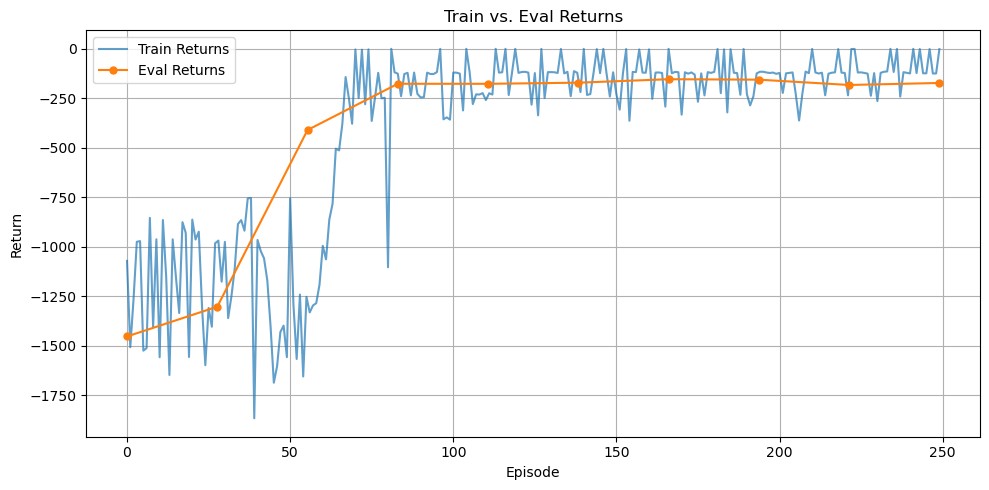

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

eval_x = np.linspace(0, len(train_returns) - 1, len(eval_returns))

plt.figure(figsize=(10, 5))
plt.plot(train_returns,     label='Train Returns', alpha=0.7)
plt.plot(eval_x, eval_returns, 'o-', label='Eval Returns', markersize=5)

plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('Train vs. Eval Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Step 5000: EvalRet=-1572.94
Step 10000: EvalRet=-1490.56
Step 15000: EvalRet=-157.79
Step 20000: EvalRet=-166.67
Step 25000: EvalRet=-166.51
Step 30000: EvalRet=-178.07
Step 35000: EvalRet=-157.16
Step 40000: EvalRet=-148.04
Step 45000: EvalRet=-140.50
Step 50000: EvalRet=-78.22
Step 55000: EvalRet=-137.48
Step 60000: EvalRet=-174.93
Step 65000: EvalRet=-162.31
Step 70000: EvalRet=-149.83
Step 75000: EvalRet=-80.73
Step 80000: EvalRet=-139.32
Step 85000: EvalRet=-140.21
Step 90000: EvalRet=-178.90
Step 95000: EvalRet=-170.63
Step 100000: EvalRet=-137.13


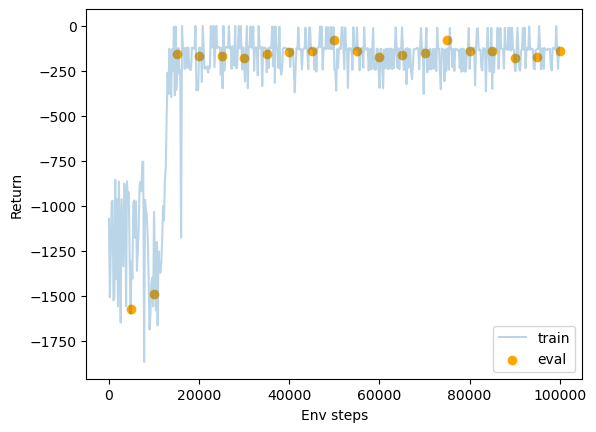

Step 5000: EvalRet=-1475.04
Step 10000: EvalRet=-1339.36
Step 15000: EvalRet=-170.44
Step 20000: EvalRet=-130.80


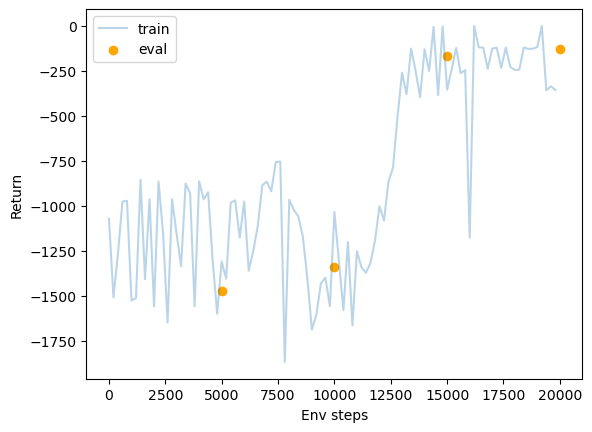

0.99 0.005 0.0003 256 256 10000 → -182.7
Step 5000: EvalRet=-1522.64
Step 10000: EvalRet=-1597.98
Step 15000: EvalRet=-1347.52
Step 20000: EvalRet=-1418.03


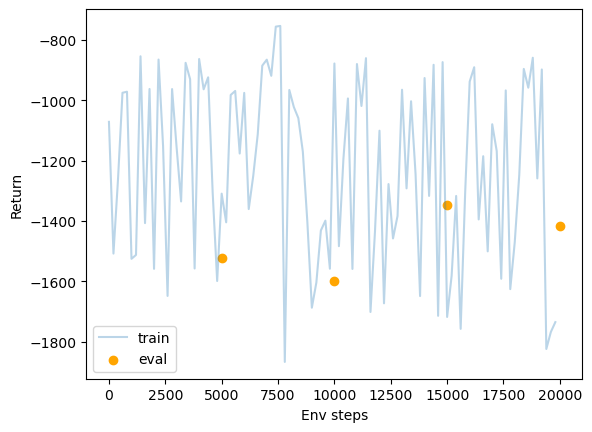

0.99 0.005 0.0003 256 256 20000 → -1616.0
Step 5000: EvalRet=-1482.56
Step 10000: EvalRet=-1564.76
Step 15000: EvalRet=-155.28
Step 20000: EvalRet=-129.44


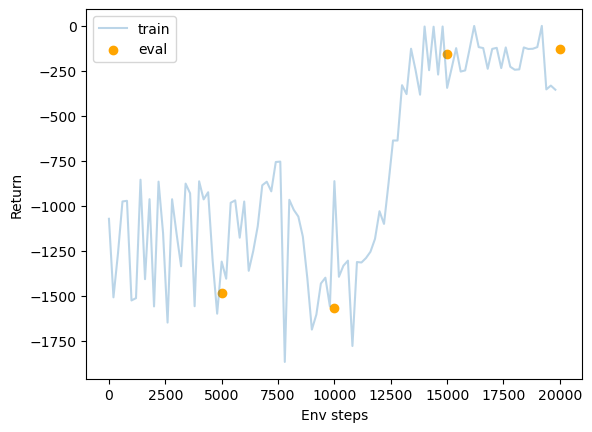

0.99 0.005 0.0003 256 512 10000 → -146.5
Step 5000: EvalRet=-1357.49
Step 10000: EvalRet=-1365.64
Step 15000: EvalRet=-1450.19
Step 20000: EvalRet=-1491.00


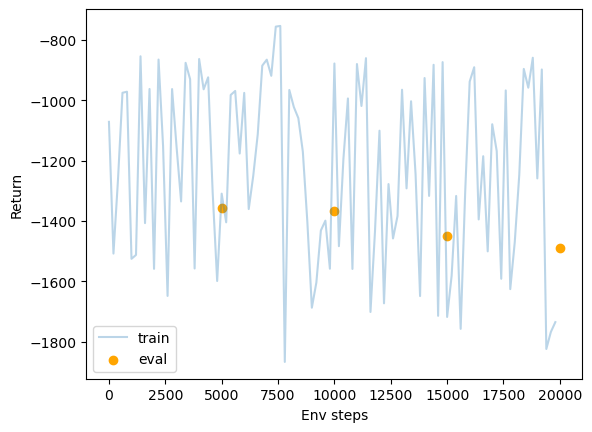

0.99 0.005 0.0003 256 512 20000 → -1302.7
Step 5000: EvalRet=-1050.65
Step 10000: EvalRet=-1191.55
Step 15000: EvalRet=-200.18
Step 20000: EvalRet=-155.63


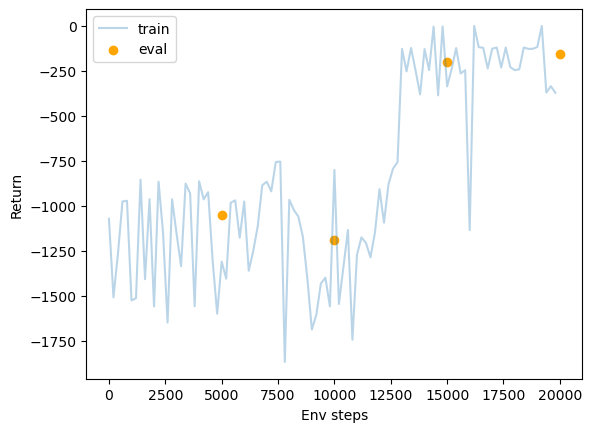

0.99 0.005 0.0003 512 256 10000 → -121.3
Step 5000: EvalRet=-1051.00
Step 10000: EvalRet=-1201.96
Step 15000: EvalRet=-1115.69
Step 20000: EvalRet=-1202.64


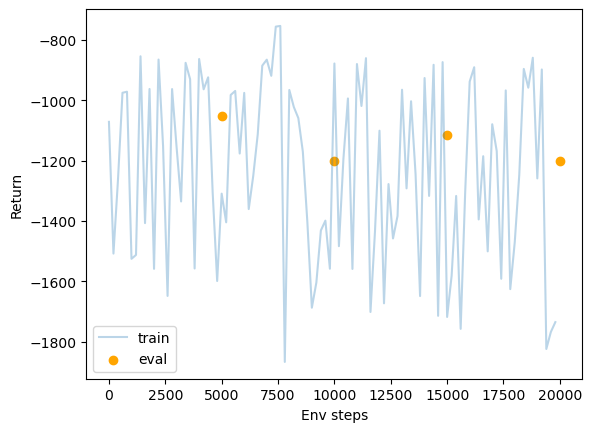

0.99 0.005 0.0003 512 256 20000 → -1304.0
Step 5000: EvalRet=-1152.99
Step 10000: EvalRet=-1161.16
Step 15000: EvalRet=-495.15
Step 20000: EvalRet=-131.37


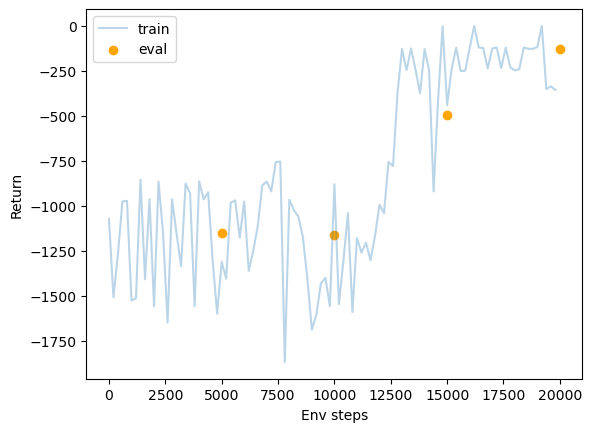

0.99 0.005 0.0003 512 512 10000 → -182.7
Step 5000: EvalRet=-1136.02
Step 10000: EvalRet=-1035.34
Step 15000: EvalRet=-1370.06
Step 20000: EvalRet=-1093.11


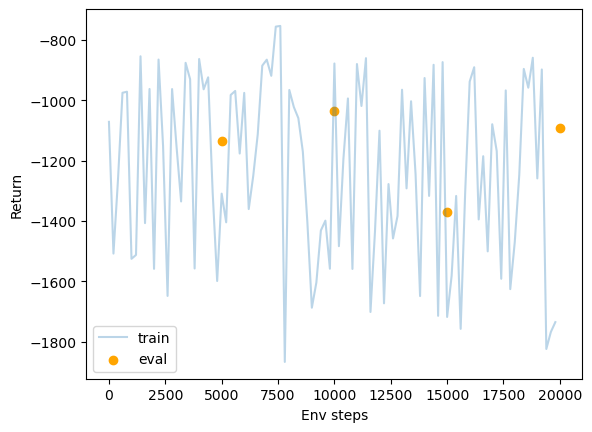

0.99 0.005 0.0003 512 512 20000 → -1300.1
Step 5000: EvalRet=-1540.34
Step 10000: EvalRet=-1475.24
Step 15000: EvalRet=-147.34
Step 20000: EvalRet=-171.66


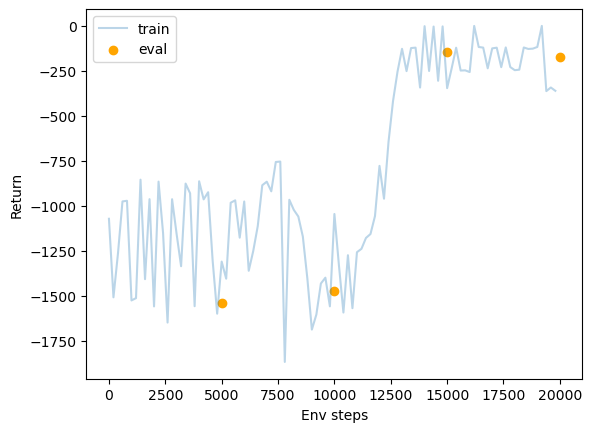

0.99 0.005 0.001 256 256 10000 → -96.5
Step 5000: EvalRet=-1628.56
Step 10000: EvalRet=-1534.32
Step 15000: EvalRet=-1516.17
Step 20000: EvalRet=-1525.95


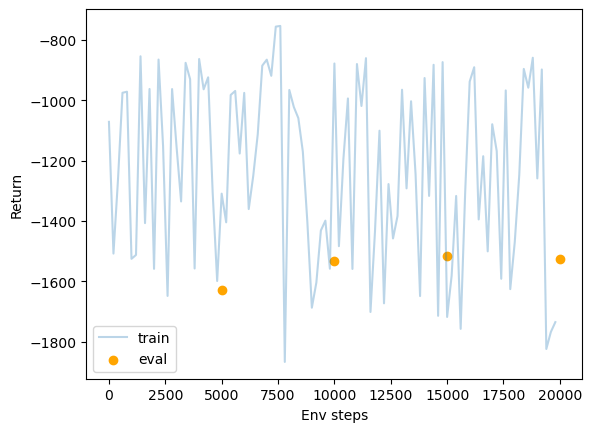

0.99 0.005 0.001 256 256 20000 → -1556.1
Step 5000: EvalRet=-1455.60
Step 10000: EvalRet=-1441.52
Step 15000: EvalRet=-190.64
Step 20000: EvalRet=-151.51


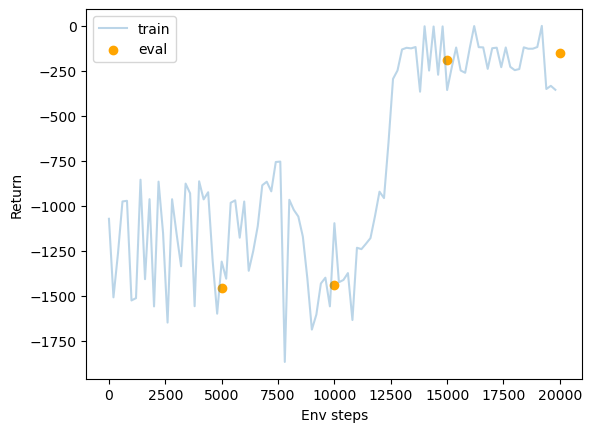

0.99 0.005 0.001 256 512 10000 → -97.1
Step 5000: EvalRet=-1561.03
Step 10000: EvalRet=-1566.93
Step 15000: EvalRet=-1525.01
Step 20000: EvalRet=-1616.26


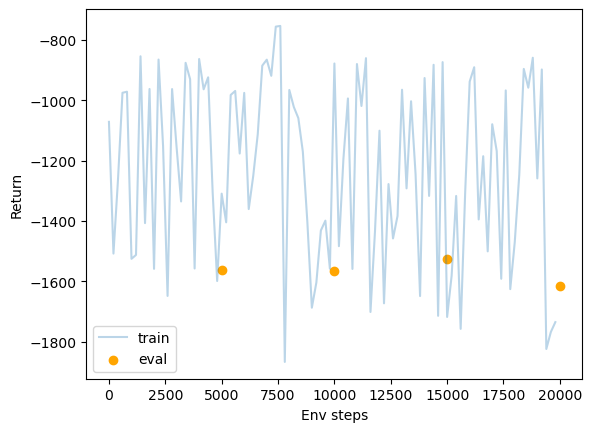

0.99 0.005 0.001 256 512 20000 → -1331.3
Step 5000: EvalRet=-1046.00
Step 10000: EvalRet=-1301.37
Step 15000: EvalRet=-197.45
Step 20000: EvalRet=-141.36


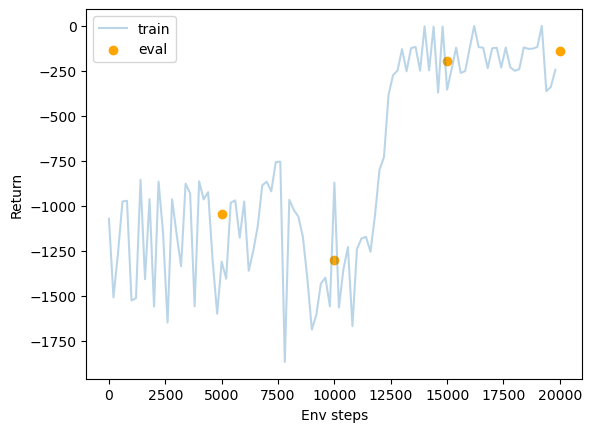

0.99 0.005 0.001 512 256 10000 → -218.9
Step 5000: EvalRet=-1252.11
Step 10000: EvalRet=-1056.53
Step 15000: EvalRet=-1056.61
Step 20000: EvalRet=-1109.83


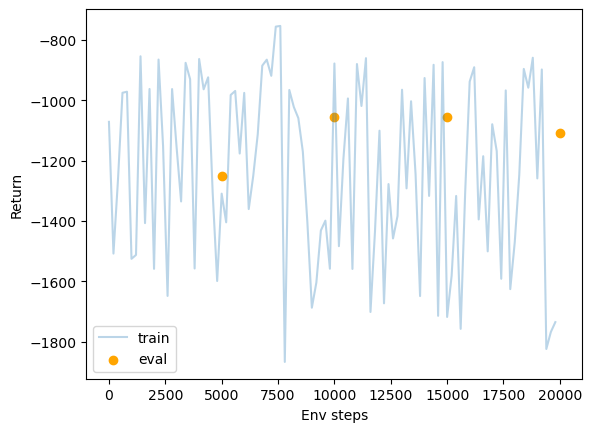

0.99 0.005 0.001 512 256 20000 → -1250.4
Step 5000: EvalRet=-1165.24
Step 10000: EvalRet=-1142.75
Step 15000: EvalRet=-168.72
Step 20000: EvalRet=-165.92


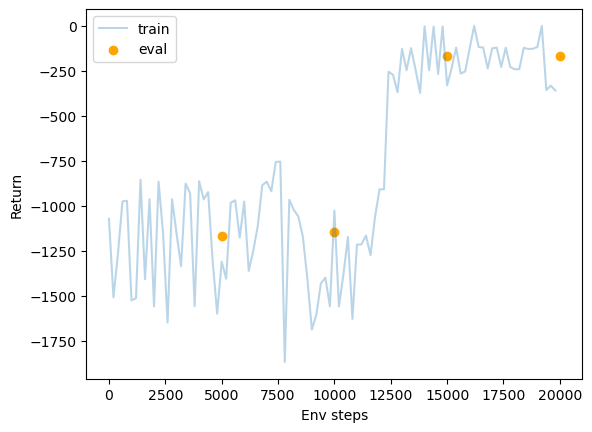

0.99 0.005 0.001 512 512 10000 → -163.4
Step 5000: EvalRet=-1263.35
Step 10000: EvalRet=-1118.86
Step 15000: EvalRet=-1111.59
Step 20000: EvalRet=-1141.62


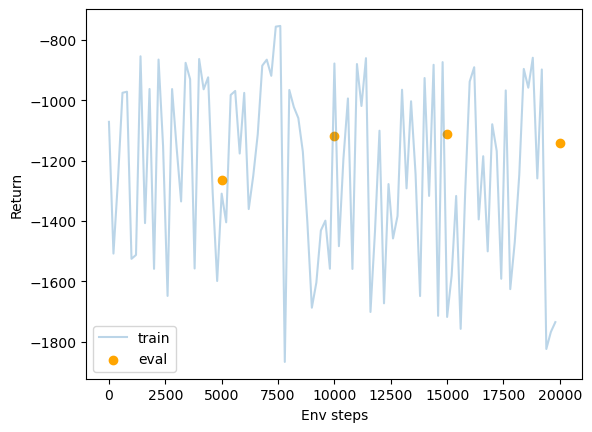

0.99 0.005 0.001 512 512 20000 → -1284.4
Step 5000: EvalRet=-1553.89
Step 10000: EvalRet=-1500.44
Step 15000: EvalRet=-121.54
Step 20000: EvalRet=-108.85


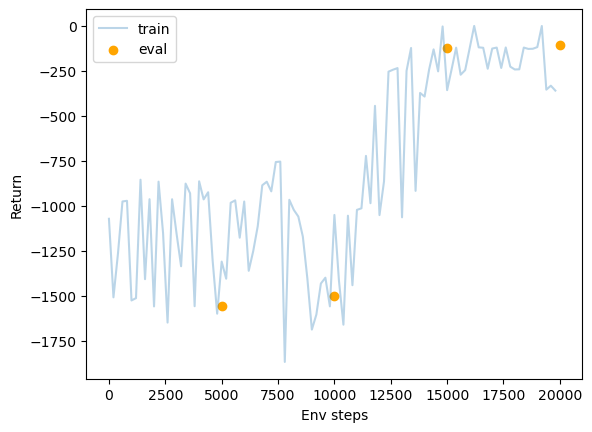

0.99 0.01 0.0003 256 256 10000 → -95.9
Step 5000: EvalRet=-1491.92
Step 10000: EvalRet=-1630.22
Step 15000: EvalRet=-1413.54
Step 20000: EvalRet=-1485.72


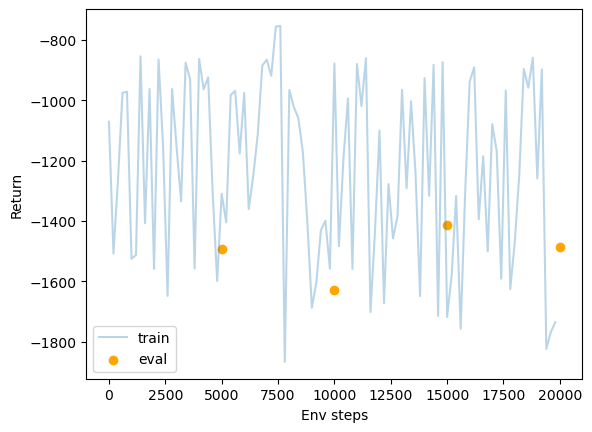

0.99 0.01 0.0003 256 256 20000 → -1411.6
Step 5000: EvalRet=-1474.71
Step 10000: EvalRet=-1488.54
Step 15000: EvalRet=-108.92
Step 20000: EvalRet=-141.65


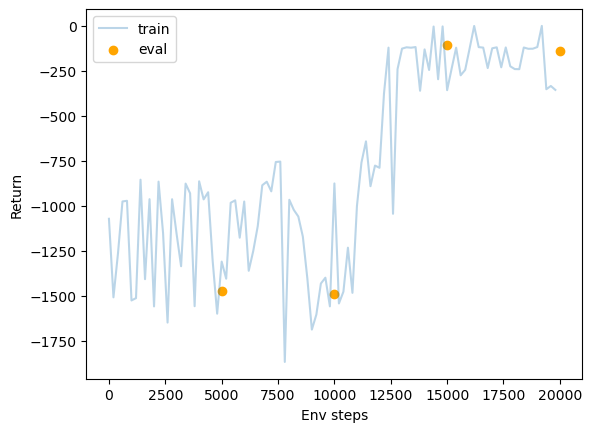

0.99 0.01 0.0003 256 512 10000 → -187.5
Step 5000: EvalRet=-1481.14
Step 10000: EvalRet=-1327.58
Step 15000: EvalRet=-1470.33
Step 20000: EvalRet=-1520.34


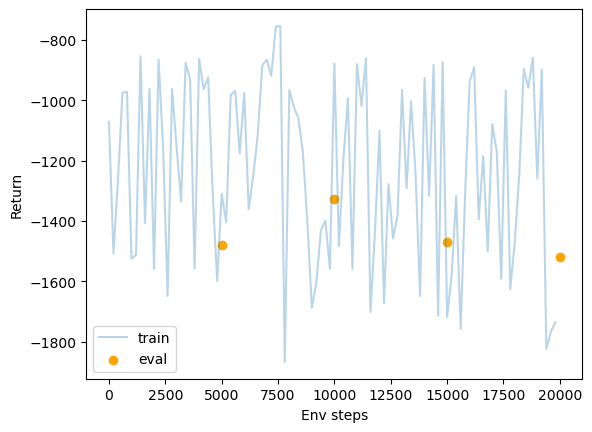

0.99 0.01 0.0003 256 512 20000 → -1538.1
Step 5000: EvalRet=-995.42
Step 10000: EvalRet=-1088.48
Step 15000: EvalRet=-146.93
Step 20000: EvalRet=-156.69


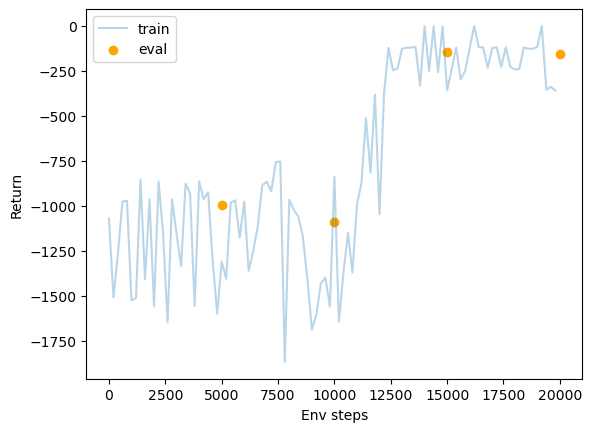

0.99 0.01 0.0003 512 256 10000 → -139.6
Step 5000: EvalRet=-1185.14
Step 10000: EvalRet=-1084.72
Step 15000: EvalRet=-1224.97
Step 20000: EvalRet=-1067.41


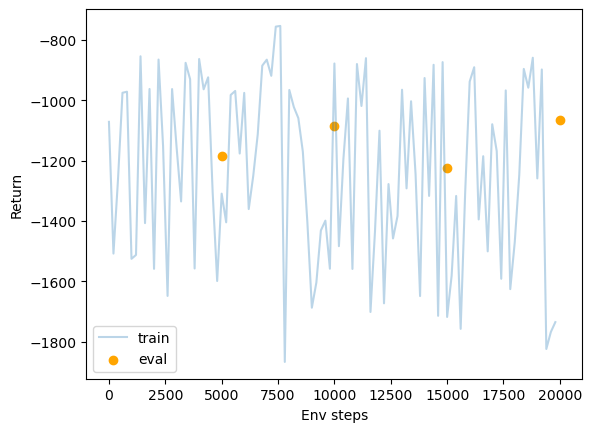

0.99 0.01 0.0003 512 256 20000 → -1001.3
Step 5000: EvalRet=-1190.22
Step 10000: EvalRet=-1151.73
Step 15000: EvalRet=-181.70
Step 20000: EvalRet=-165.19


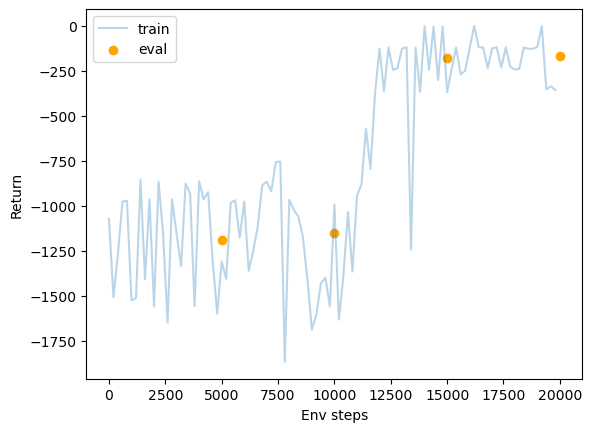

0.99 0.01 0.0003 512 512 10000 → -118.3
Step 5000: EvalRet=-1246.72
Step 10000: EvalRet=-1263.91
Step 15000: EvalRet=-1077.57
Step 20000: EvalRet=-1166.93


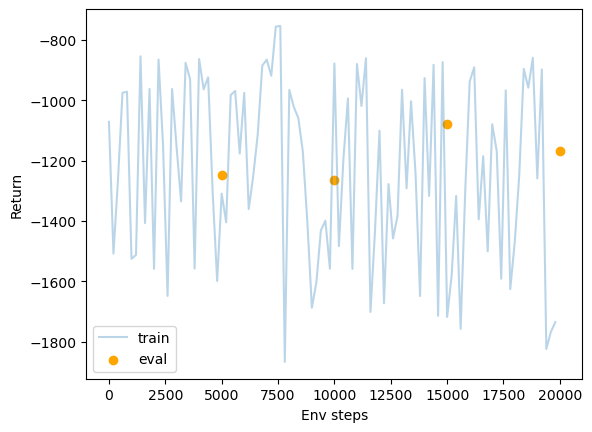

0.99 0.01 0.0003 512 512 20000 → -1151.6
Step 5000: EvalRet=-1355.44
Step 10000: EvalRet=-1355.45
Step 15000: EvalRet=-144.33
Step 20000: EvalRet=-156.23


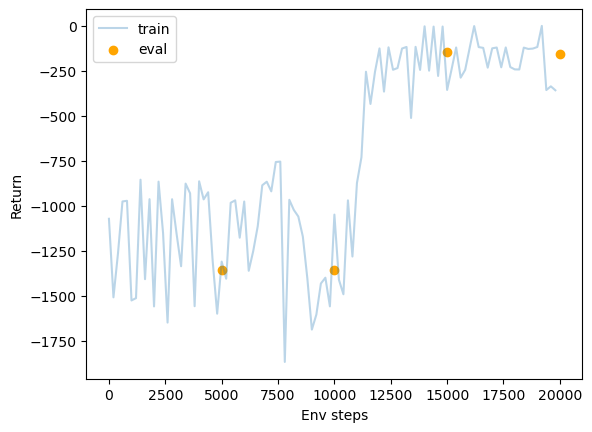

0.99 0.01 0.001 256 256 10000 → -144.4
Step 5000: EvalRet=-1418.12
Step 10000: EvalRet=-1502.85
Step 15000: EvalRet=-1480.48
Step 20000: EvalRet=-1545.49


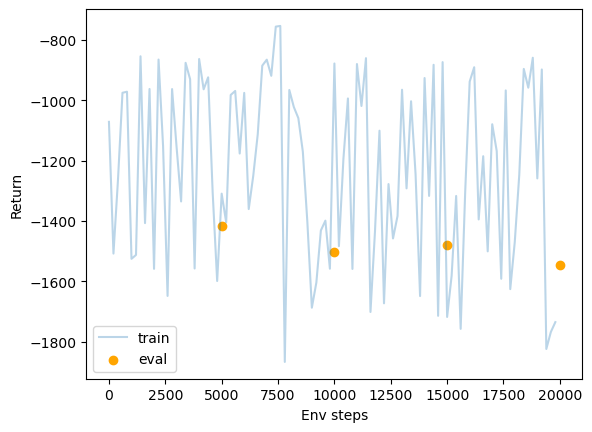

0.99 0.01 0.001 256 256 20000 → -1474.8
Step 5000: EvalRet=-1462.11
Step 10000: EvalRet=-1418.49
Step 15000: EvalRet=-162.76
Step 20000: EvalRet=-167.97


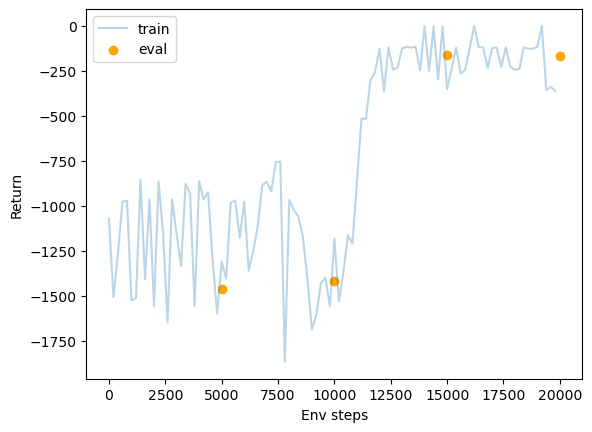

0.99 0.01 0.001 256 512 10000 → -187.2
Step 5000: EvalRet=-1530.91
Step 10000: EvalRet=-1591.25
Step 15000: EvalRet=-1454.22
Step 20000: EvalRet=-1432.77


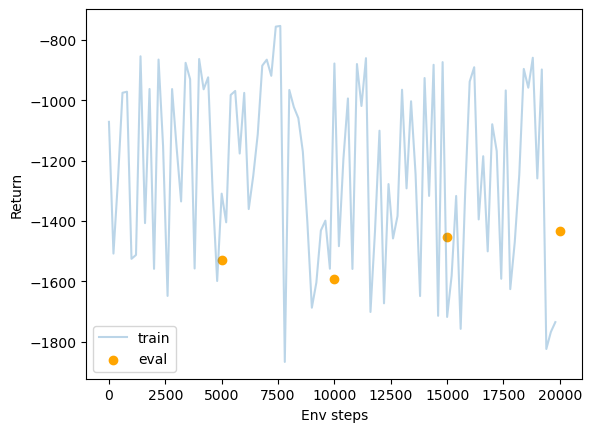

0.99 0.01 0.001 256 512 20000 → -1342.8
Step 5000: EvalRet=-1092.49
Step 10000: EvalRet=-1104.40
Step 15000: EvalRet=-191.61
Step 20000: EvalRet=-107.53


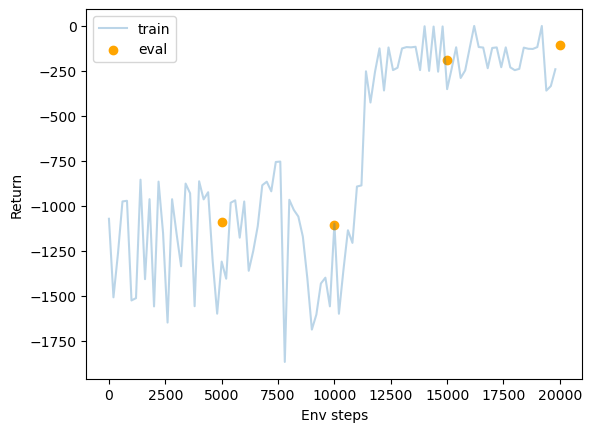

0.99 0.01 0.001 512 256 10000 → -176.5
Step 5000: EvalRet=-1015.86
Step 10000: EvalRet=-1042.67
Step 15000: EvalRet=-1242.42
Step 20000: EvalRet=-1121.78


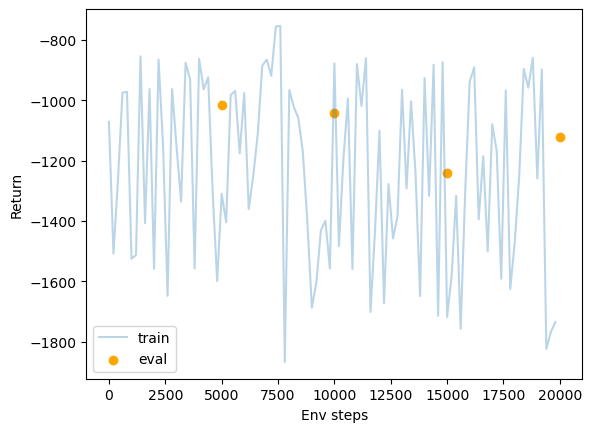

0.99 0.01 0.001 512 256 20000 → -1246.1
Step 5000: EvalRet=-1177.83
Step 10000: EvalRet=-1292.91
Step 15000: EvalRet=-157.97
Step 20000: EvalRet=-82.52


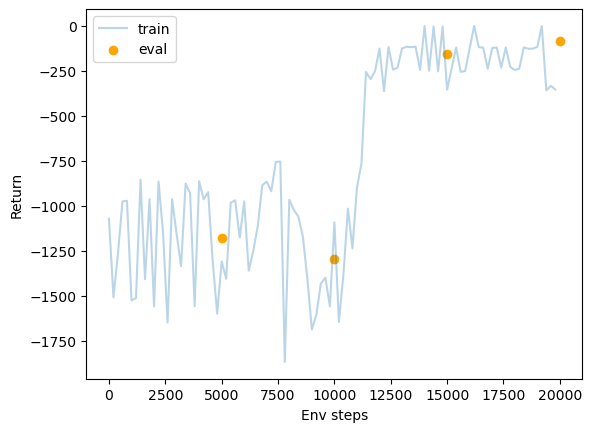

0.99 0.01 0.001 512 512 10000 → -146.0
Step 5000: EvalRet=-1192.90
Step 10000: EvalRet=-1133.58
Step 15000: EvalRet=-1207.46
Step 20000: EvalRet=-1013.44


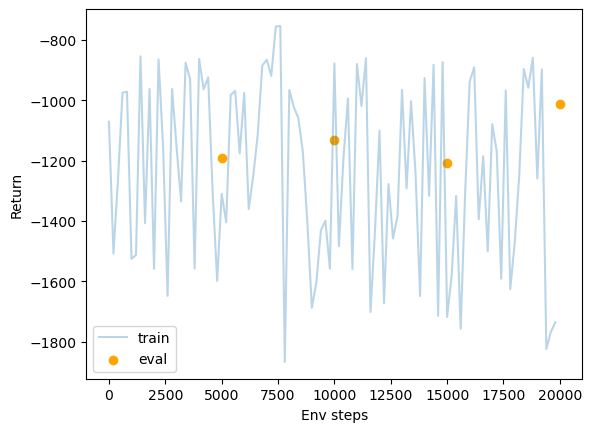

0.99 0.01 0.001 512 512 20000 → -971.8
Step 5000: EvalRet=-1513.64
Step 10000: EvalRet=-1511.47
Step 15000: EvalRet=-285.61
Step 20000: EvalRet=-174.69


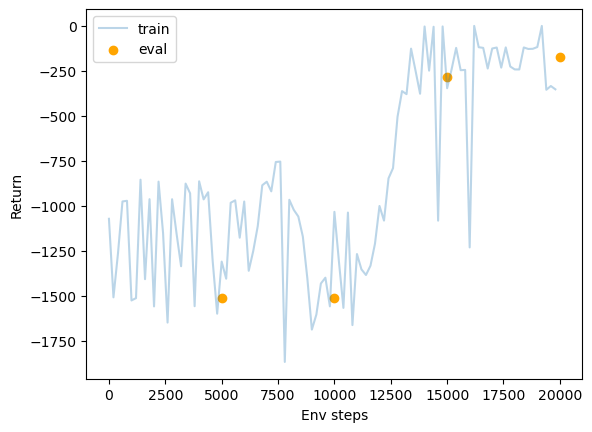

0.997 0.005 0.0003 256 256 10000 → -144.6
Step 5000: EvalRet=-1538.59
Step 10000: EvalRet=-1608.97
Step 15000: EvalRet=-1564.81
Step 20000: EvalRet=-1436.48


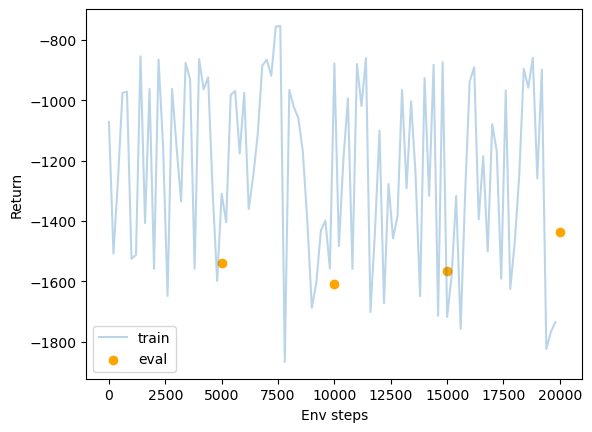

0.997 0.005 0.0003 256 256 20000 → -1565.7
Step 5000: EvalRet=-1446.14
Step 10000: EvalRet=-1505.31
Step 15000: EvalRet=-230.57
Step 20000: EvalRet=-130.32


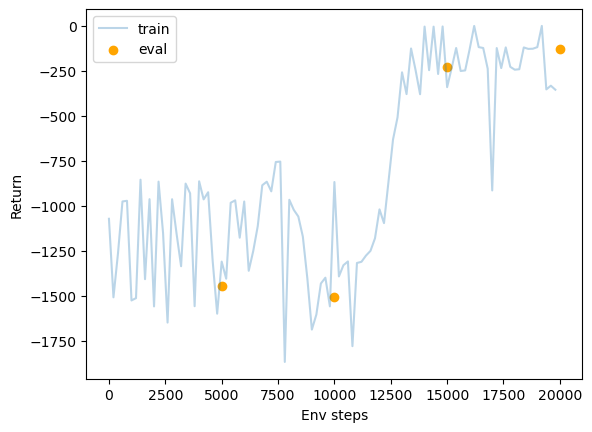

0.997 0.005 0.0003 256 512 10000 → -208.7
Step 5000: EvalRet=-1601.60
Step 10000: EvalRet=-1356.91
Step 15000: EvalRet=-1523.05
Step 20000: EvalRet=-1592.27


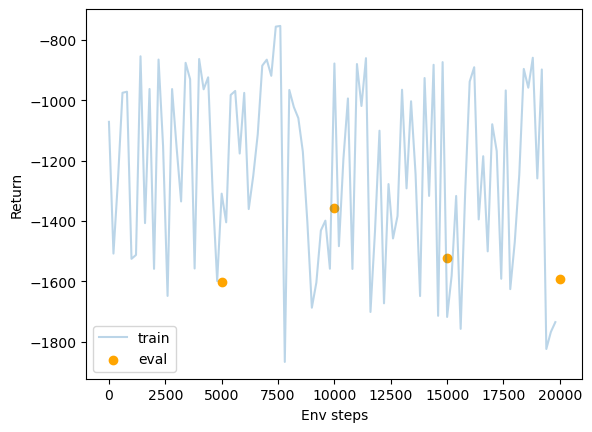

0.997 0.005 0.0003 256 512 20000 → -1576.5
Step 5000: EvalRet=-992.09
Step 10000: EvalRet=-1148.74
Step 15000: EvalRet=-372.50
Step 20000: EvalRet=-174.90


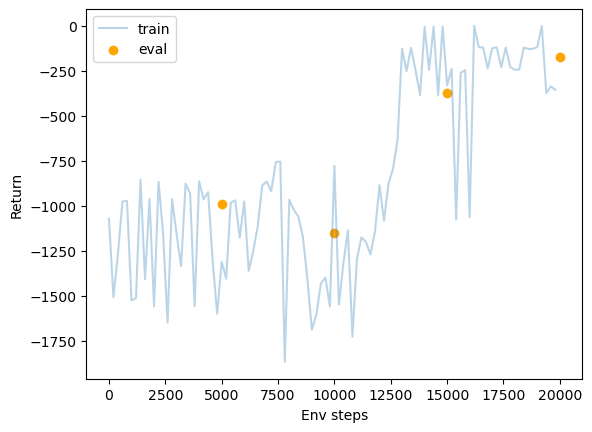

0.997 0.005 0.0003 512 256 10000 → -218.2
Step 5000: EvalRet=-1388.09
Step 10000: EvalRet=-1114.73
Step 15000: EvalRet=-1215.75
Step 20000: EvalRet=-986.18


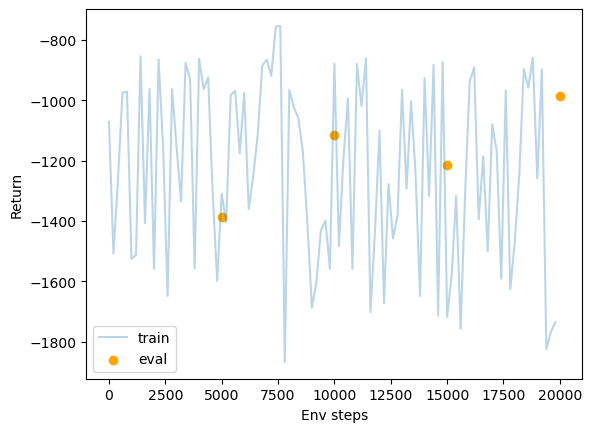

0.997 0.005 0.0003 512 256 20000 → -1151.9
Step 5000: EvalRet=-1291.94
Step 10000: EvalRet=-1090.02
Step 15000: EvalRet=-368.30
Step 20000: EvalRet=-107.57


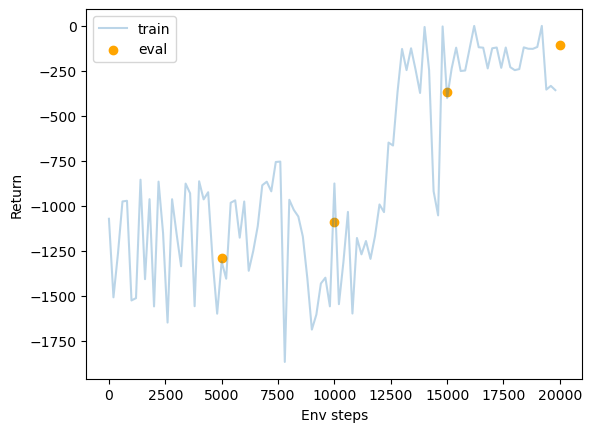

0.997 0.005 0.0003 512 512 10000 → -95.4
Step 5000: EvalRet=-1212.62
Step 10000: EvalRet=-1083.96
Step 15000: EvalRet=-1051.88
Step 20000: EvalRet=-1124.11


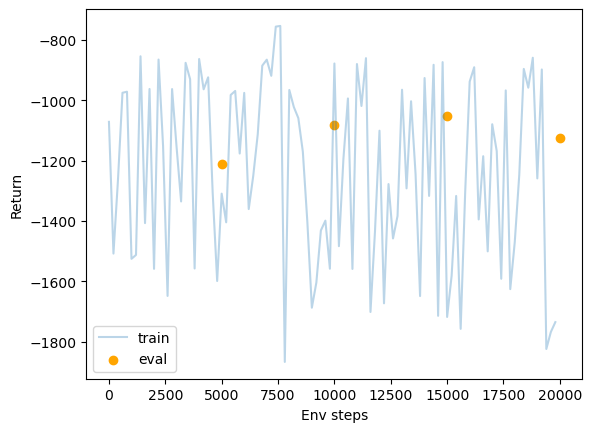

0.997 0.005 0.0003 512 512 20000 → -1100.5
Step 5000: EvalRet=-1476.82
Step 10000: EvalRet=-1608.57
Step 15000: EvalRet=-167.08
Step 20000: EvalRet=-155.32


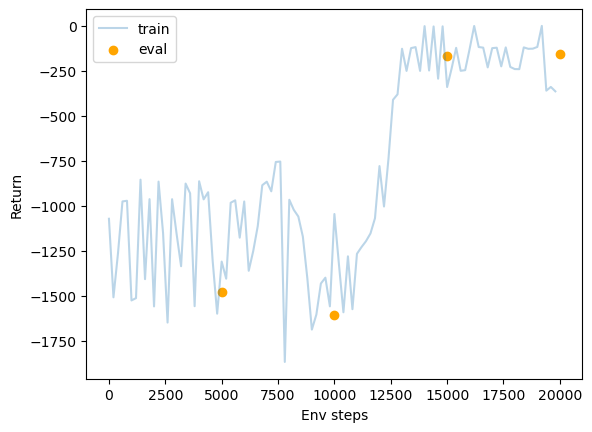

0.997 0.005 0.001 256 256 10000 → -165.4
Step 5000: EvalRet=-1633.54
Step 10000: EvalRet=-1485.43
Step 15000: EvalRet=-1613.16
Step 20000: EvalRet=-1410.18


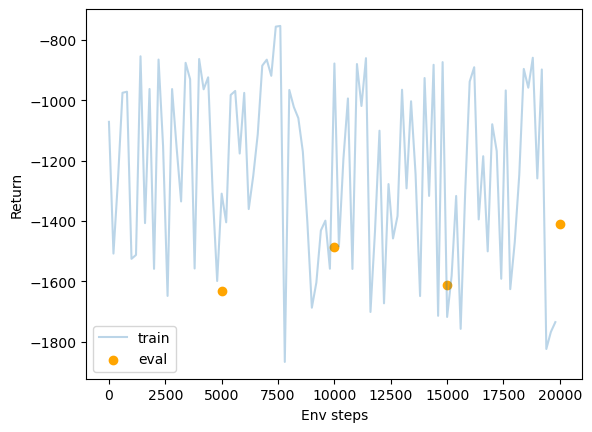

0.997 0.005 0.001 256 256 20000 → -1473.0
Step 5000: EvalRet=-1444.72
Step 10000: EvalRet=-1581.86
Step 15000: EvalRet=-223.90
Step 20000: EvalRet=-180.20


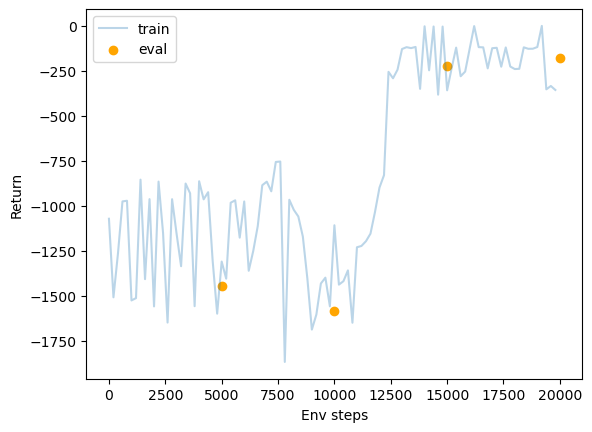

0.997 0.005 0.001 256 512 10000 → -121.2
Step 5000: EvalRet=-1521.05
Step 10000: EvalRet=-1424.50
Step 15000: EvalRet=-1572.22
Step 20000: EvalRet=-1509.77


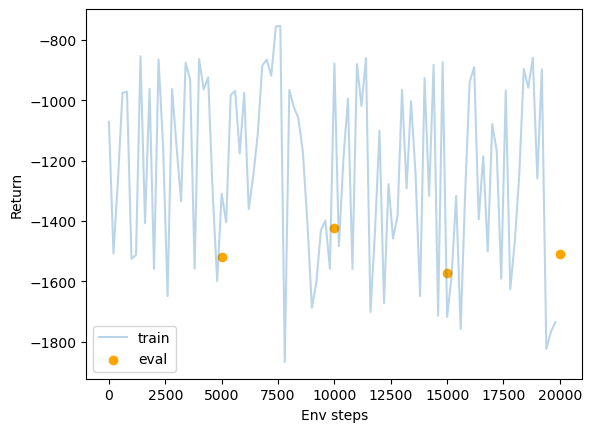

0.997 0.005 0.001 256 512 20000 → -1627.7
Step 5000: EvalRet=-1158.22
Step 10000: EvalRet=-1057.35
Step 15000: EvalRet=-145.85
Step 20000: EvalRet=-176.09


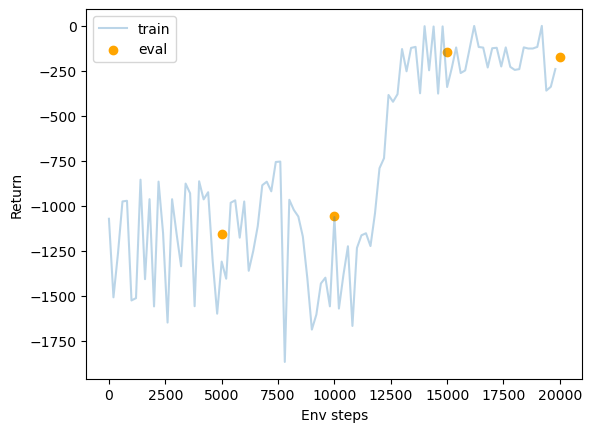

0.997 0.005 0.001 512 256 10000 → -142.8
Step 5000: EvalRet=-1203.30
Step 10000: EvalRet=-1148.98
Step 15000: EvalRet=-1452.62
Step 20000: EvalRet=-1203.99


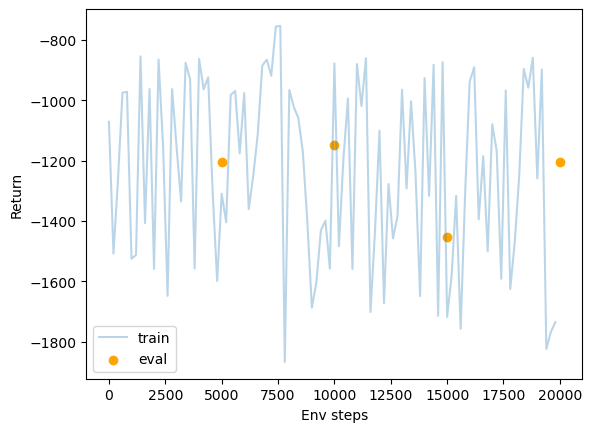

0.997 0.005 0.001 512 256 20000 → -1153.3
Step 5000: EvalRet=-1019.33
Step 10000: EvalRet=-1177.79
Step 15000: EvalRet=-143.79
Step 20000: EvalRet=-212.72


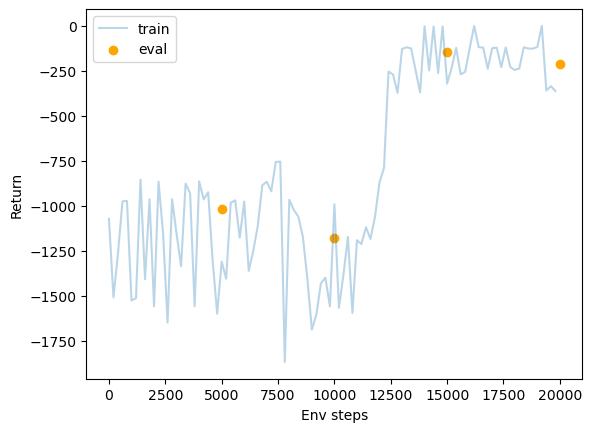

0.997 0.005 0.001 512 512 10000 → -169.7
Step 5000: EvalRet=-1261.72
Step 10000: EvalRet=-908.39
Step 15000: EvalRet=-1189.66
Step 20000: EvalRet=-1034.54


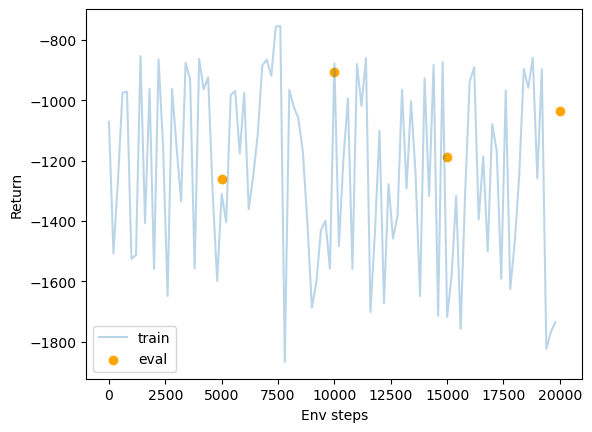

0.997 0.005 0.001 512 512 20000 → -1125.6
Step 5000: EvalRet=-1602.23
Step 10000: EvalRet=-1479.12
Step 15000: EvalRet=-159.11
Step 20000: EvalRet=-173.87


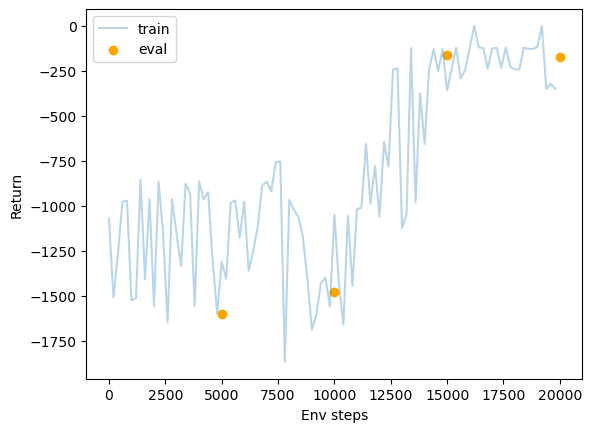

0.997 0.01 0.0003 256 256 10000 → -142.4
Step 5000: EvalRet=-1489.75
Step 10000: EvalRet=-1459.85
Step 15000: EvalRet=-1404.75
Step 20000: EvalRet=-1533.06


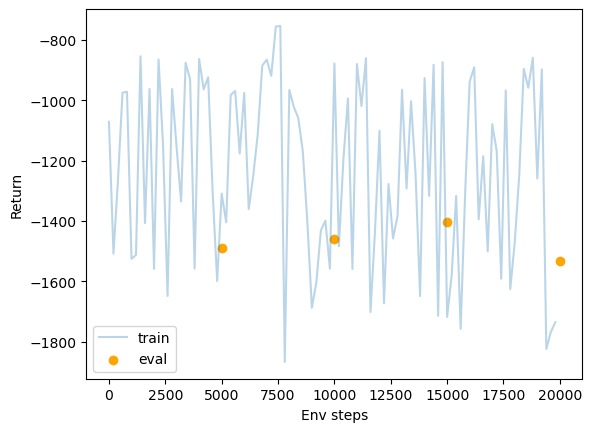

0.997 0.01 0.0003 256 256 20000 → -1722.1
Step 5000: EvalRet=-1463.56
Step 10000: EvalRet=-1491.96
Step 15000: EvalRet=-168.90
Step 20000: EvalRet=-131.34


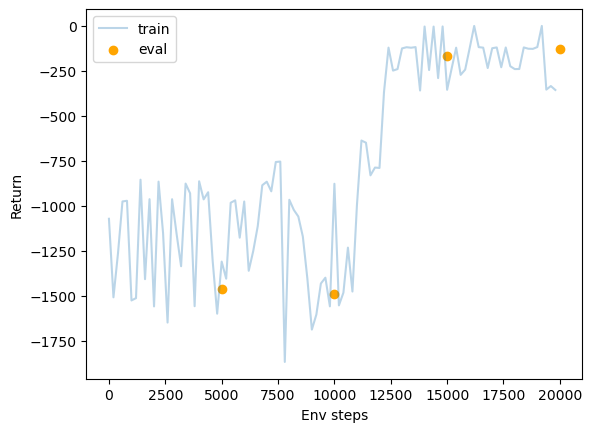

0.997 0.01 0.0003 256 512 10000 → -153.8
Step 5000: EvalRet=-1373.72
Step 10000: EvalRet=-1493.92
Step 15000: EvalRet=-1571.10
Step 20000: EvalRet=-1686.91


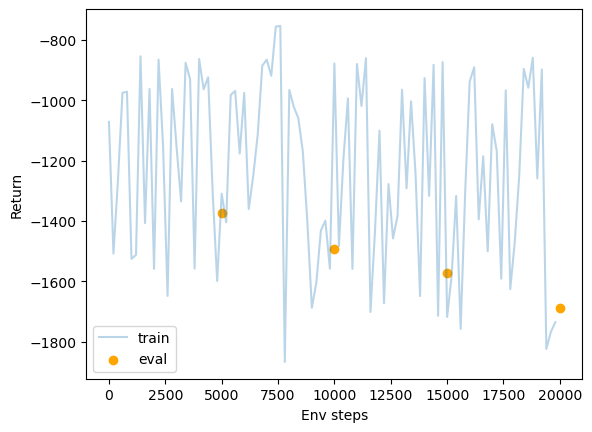

0.997 0.01 0.0003 256 512 20000 → -1425.1
Step 5000: EvalRet=-1127.94
Step 10000: EvalRet=-1123.63
Step 15000: EvalRet=-180.83
Step 20000: EvalRet=-177.76


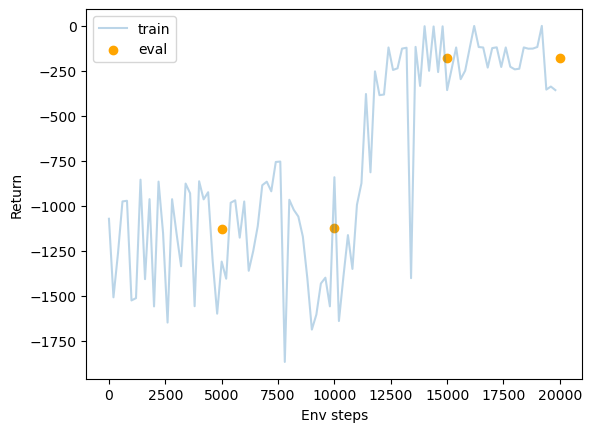

0.997 0.01 0.0003 512 256 10000 → -120.3
Step 5000: EvalRet=-1086.07
Step 10000: EvalRet=-1251.90
Step 15000: EvalRet=-1109.96
Step 20000: EvalRet=-1035.47


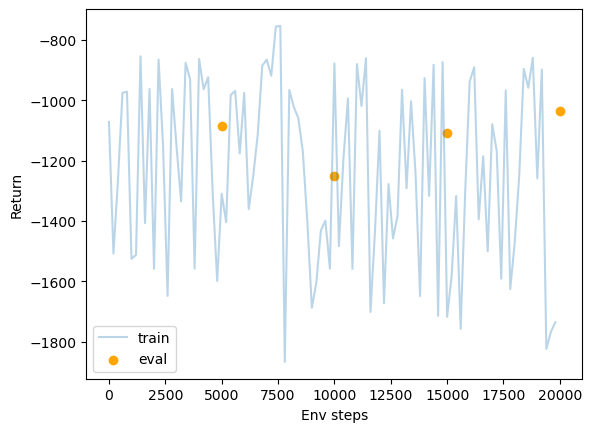

0.997 0.01 0.0003 512 256 20000 → -1073.4
Step 5000: EvalRet=-1057.47
Step 10000: EvalRet=-1284.96
Step 15000: EvalRet=-131.38
Step 20000: EvalRet=-179.51


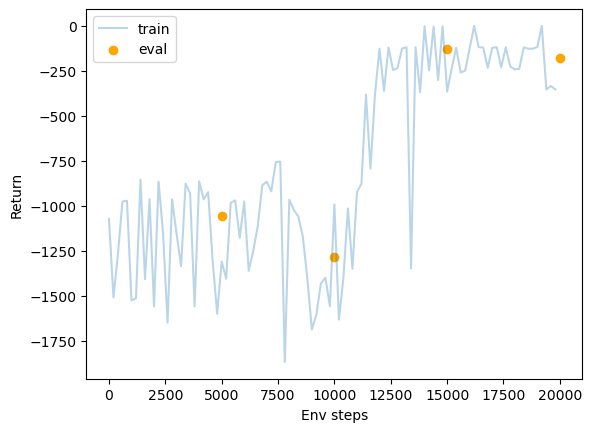

0.997 0.01 0.0003 512 512 10000 → -95.8
Step 5000: EvalRet=-1106.36
Step 10000: EvalRet=-1355.98
Step 15000: EvalRet=-1199.83
Step 20000: EvalRet=-1220.89


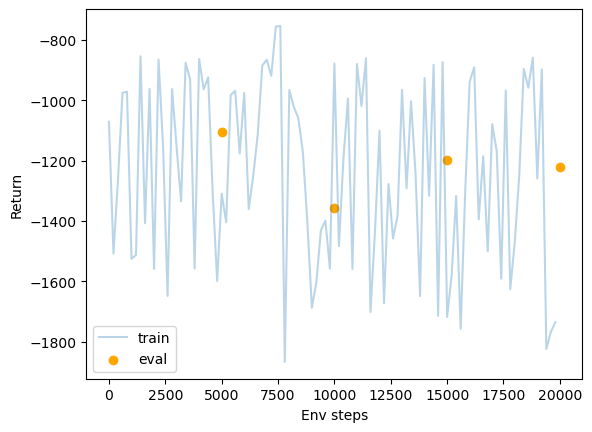

0.997 0.01 0.0003 512 512 20000 → -1026.0
Step 5000: EvalRet=-1563.41
Step 10000: EvalRet=-1469.92
Step 15000: EvalRet=-322.81
Step 20000: EvalRet=-189.38


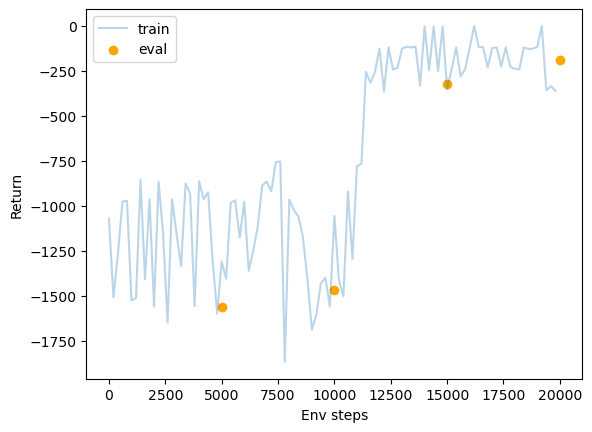

0.997 0.01 0.001 256 256 10000 → -162.1
Step 5000: EvalRet=-1491.81
Step 10000: EvalRet=-1410.49
Step 15000: EvalRet=-1575.49
Step 20000: EvalRet=-1602.78


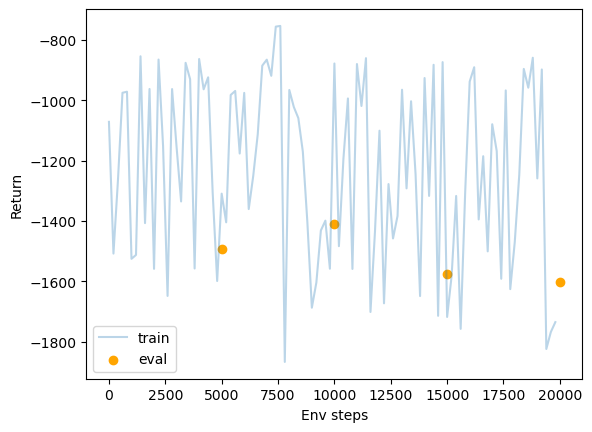

0.997 0.01 0.001 256 256 20000 → -1438.8
Step 5000: EvalRet=-1589.49
Step 10000: EvalRet=-1482.58
Step 15000: EvalRet=-164.55
Step 20000: EvalRet=-142.68


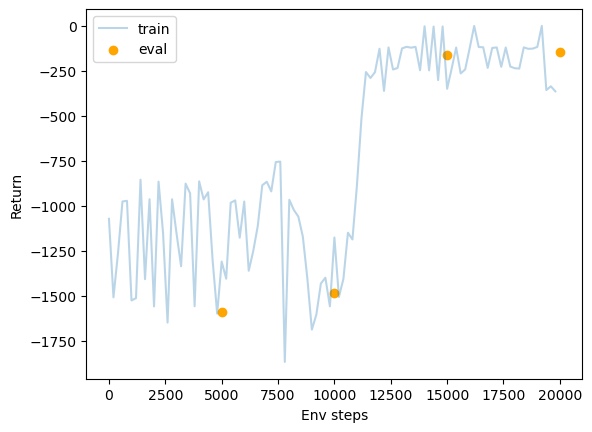

0.997 0.01 0.001 256 512 10000 → -169.4
Step 5000: EvalRet=-1612.89
Step 10000: EvalRet=-1388.00
Step 15000: EvalRet=-1565.18
Step 20000: EvalRet=-1441.97


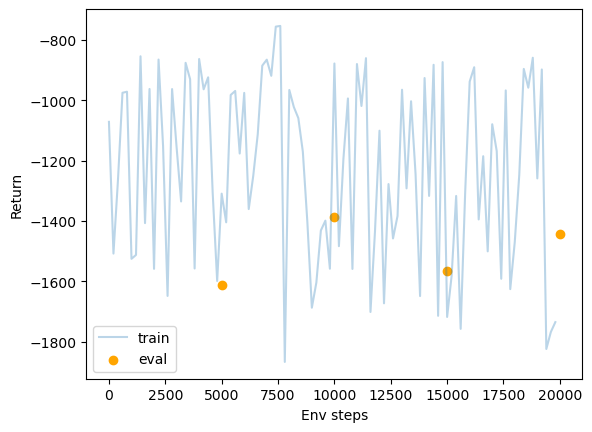

0.997 0.01 0.001 256 512 20000 → -1474.7
Step 5000: EvalRet=-1103.74
Step 10000: EvalRet=-1154.09
Step 15000: EvalRet=-168.47
Step 20000: EvalRet=-169.23


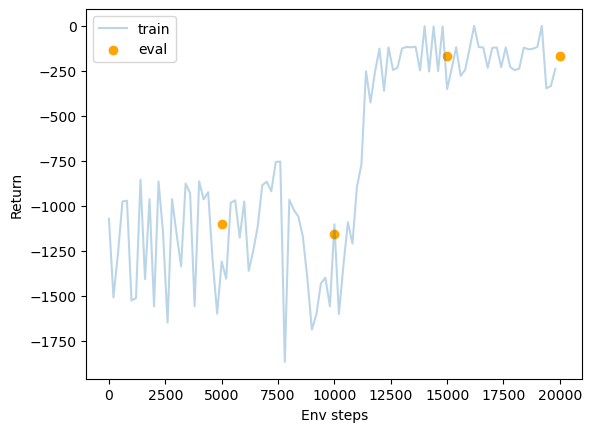

0.997 0.01 0.001 512 256 10000 → -117.7
Step 5000: EvalRet=-1262.63
Step 10000: EvalRet=-1125.57
Step 15000: EvalRet=-1175.84
Step 20000: EvalRet=-1044.45


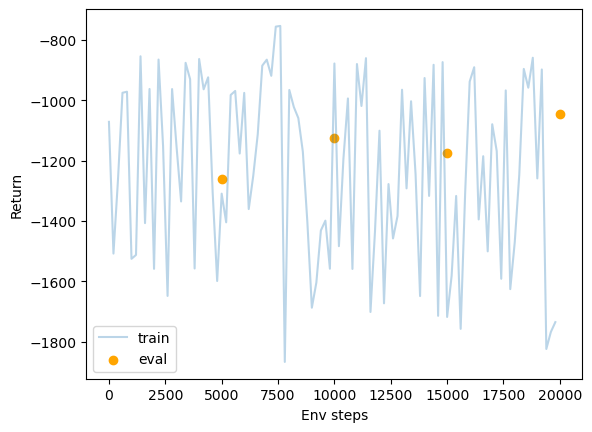

0.997 0.01 0.001 512 256 20000 → -1219.5
Step 5000: EvalRet=-1061.35
Step 10000: EvalRet=-1117.95
Step 15000: EvalRet=-141.70
Step 20000: EvalRet=-109.78


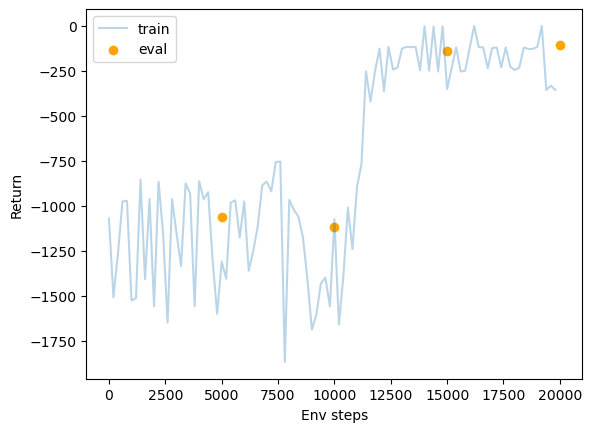

0.997 0.01 0.001 512 512 10000 → -96.3
Step 5000: EvalRet=-1007.03
Step 10000: EvalRet=-1074.17
Step 15000: EvalRet=-1080.59
Step 20000: EvalRet=-1234.06


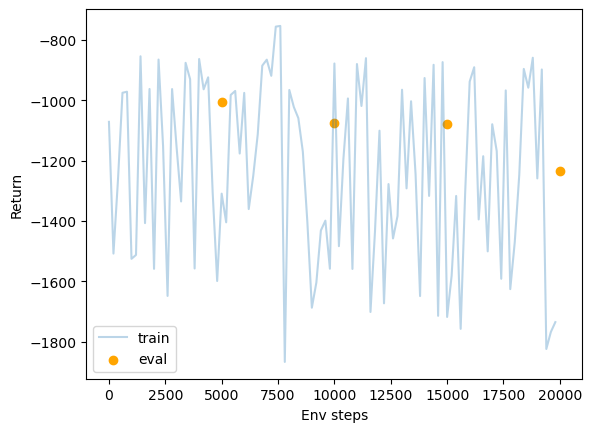

0.997 0.01 0.001 512 512 20000 → -1004.3
Top 5: [(0.997, 0.005, 0.0003, 512, 512, 10000, -95.35406127593168), (0.997, 0.01, 0.0003, 512, 512, 10000, -95.82193634367883), (0.99, 0.01, 0.0003, 256, 256, 10000, -95.90736701022391), (0.997, 0.01, 0.001, 512, 512, 10000, -96.34317787360776), (0.99, 0.005, 0.001, 256, 256, 10000, -96.47966508027079)]


In [ ]:
import gymnasium as gym
import numpy as np
import torch
import matplotlib.pyplot as plt
from itertools import product


# created with help of OpenAI
# baseline
ENV_NAME            = "Pendulum-v1"
EXPLORATION_STEPS   = 10_000      
EVAL_FREQ           = 5_000       
EVAL_EPISODES       = 10          

OBS_SIZE            = gym.make(ENV_NAME).observation_space.shape[0]
ACT_SIZE            = gym.make(ENV_NAME).action_space.shape[0]
ACT_LIMIT           = float(gym.make(ENV_NAME).action_space.high[0])

# default 
GAMMA               = 0.99
TAU                 = 0.005
LR_POLICY           = 3e-4
LR_Q                = 3e-4
LR_ALPHA            = 3e-4
AUTO_ENTROPY        = True
TARGET_ENTROPY      = -ACT_SIZE
HIDDEN_DIM          = 256
BATCH_SIZE          = 256

# network 
class Actor(torch.nn.Module):
    def __init__(self, state_dim, action_dim, max_action, hidden_dim):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(state_dim, hidden_dim), torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU()
        )
        self.mean    = torch.nn.Linear(hidden_dim, action_dim)
        self.log_std = torch.nn.Linear(hidden_dim, action_dim)
        self.max_act = max_action

    def forward(self, obs):
        h      = self.net(obs)
        mu     = self.mean(h)
        logstd = self.log_std(h).clamp(-20, 2)
        std    = torch.exp(logstd)
        dist   = torch.distributions.Normal(mu, std)
        x_t    = dist.rsample()
        y      = torch.tanh(x_t)
        act    = y * self.max_act
        logp   = dist.log_prob(x_t).sum(1, keepdim=True)
        # Jacobian
        logp  -= (torch.log(self.max_act * (1 - y.pow(2)) + 1e-6)
                  ).sum(1, keepdim=True)
        return act, logp

class Critic(torch.nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super().__init__()
        in_dim = state_dim + action_dim
        self.q1 = torch.nn.Sequential(
            torch.nn.Linear(in_dim, hidden_dim), torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )
        self.q2 = torch.nn.Sequential(
            torch.nn.Linear(in_dim, hidden_dim), torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )

    def forward(self, obs, act):
        x = torch.cat([obs, act], dim=1)
        return self.q1(x), self.q2(x)

class ReplayBuffer:
    def __init__(self, state_dim, action_dim, max_size=int(1e6)):
        self.max_size = max_size
        self.ptr, self.size = 0, 0
        self.obs_buf      = np.zeros((max_size, state_dim), dtype=np.float32)
        self.act_buf      = np.zeros((max_size, action_dim), dtype=np.float32)
        self.next_obs_buf = np.zeros((max_size, state_dim), dtype=np.float32)
        self.rew_buf      = np.zeros((max_size, 1), dtype=np.float32)
        self.done_buf     = np.zeros((max_size, 1), dtype=np.float32)

    def add(self, obs, act, next_obs, rew, done):
        self.obs_buf[self.ptr]      = obs
        self.act_buf[self.ptr]      = act
        self.next_obs_buf[self.ptr] = next_obs
        self.rew_buf[self.ptr]      = rew
        self.done_buf[self.ptr]     = float(done)
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        idx = np.random.randint(0, self.size, size=batch_size)
        return (
            torch.FloatTensor(self.obs_buf[idx]),
            torch.FloatTensor(self.act_buf[idx]),
            torch.FloatTensor(self.next_obs_buf[idx]),
            torch.FloatTensor(self.rew_buf[idx]),
            torch.FloatTensor(self.done_buf[idx]),
        )

class SAC:
    def __init__(self, state_dim, action_dim, max_action,
                 discount, tau, lr_policy, lr_q, lr_alpha, auto_entropy,
                 hidden_dim, target_entropy):
        self.device = torch.device('cpu')
        self.actor         = Actor(state_dim, action_dim, max_action, hidden_dim).to(self.device)
        self.critic        = Critic(state_dim, action_dim, hidden_dim).to(self.device)
        self.critic_target = Critic(state_dim, action_dim, hidden_dim).to(self.device)
        # copy weights
        for tp, p in zip(self.critic_target.parameters(), self.critic.parameters()):
            tp.data.copy_(p.data)
        # optimizers
        self.actor_opt  = torch.optim.Adam(self.actor.parameters(), lr=lr_policy)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=lr_q)
        
        self.max_action = max_action
        self.discount   = discount
        self.tau        = tau

        # entropy alpha
        self.auto_entropy = auto_entropy
        if auto_entropy:
            self.target_entropy = target_entropy
            self.log_alpha       = torch.zeros(1, requires_grad=True, device=self.device)
            self.alpha_opt       = torch.optim.Adam([self.log_alpha], lr=lr_alpha)
            self.alpha           = self.log_alpha.exp()
        else:
            self.alpha = torch.tensor(0.2)

    def select_action(self, obs, evaluate=False):
        obs_t = torch.FloatTensor(obs).unsqueeze(0).to(self.device)
        with torch.no_grad():
            if evaluate:
                h = self.actor.net(obs_t)
                mu = self.actor.mean(h)
                return (torch.tanh(mu) * self.max_action).cpu().numpy().flatten()
            a, _ = self.actor(obs_t)
            return a.cpu().numpy().flatten()

    def train(self, buffer, batch_size):
        obs, act, obs2, rew, done = buffer.sample(batch_size)
        obs, act, obs2, rew, done = [t.to(self.device) for t in (obs, act, obs2, rew, done)]
        # target Q
        with torch.no_grad():
            a2, logp2        = self.actor(obs2)
            q1_t, q2_t       = self.critic_target(obs2, a2)
            q_target         = torch.min(q1_t, q2_t) - self.alpha * logp2
            backup           = rew + (1 - done) * self.discount * q_target
        # critic loss & update
        q1, q2           = self.critic(obs, act)
        loss_q           = torch.nn.functional.mse_loss(q1, backup) + torch.nn.functional.mse_loss(q2, backup)
        self.critic_opt.zero_grad()
        loss_q.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 1.0)
        self.critic_opt.step()
        # actor loss & update
        a_new, logp       = self.actor(obs)
        q1n, q2n          = self.critic(obs, a_new)
        loss_pi           = (self.alpha * logp - torch.min(q1n, q2n)).mean()
        self.actor_opt.zero_grad()
        loss_pi.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 1.0)
        self.actor_opt.step()
        # alpha loss
        if self.auto_entropy:
            loss_alpha = -(self.log_alpha * (logp + self.target_entropy).detach()).mean()
            self.alpha_opt.zero_grad()
            loss_alpha.backward()
            self.alpha_opt.step()
            self.alpha = self.log_alpha.exp()
        # soft update
        for tp, p in zip(self.critic_target.parameters(), self.critic.parameters()):
            tp.data.copy_(tp.data * (1 - self.tau) + p.data * self.tau)
        return loss_q.item(), loss_pi.item(), self.alpha.item()

# training, evaluation, and hyperparameter tuning
def train_sac(max_steps, batch_size, gamma, tau, lr_p, lr_q, lr_a,
              auto_entropy, hidden_dim, target_entropy):
    env = gym.make(ENV_NAME)
    eval_env = gym.make(ENV_NAME)
    torch.manual_seed(0); np.random.seed(0); env.action_space.seed(0)

    agent  = SAC(OBS_SIZE, ACT_SIZE, ACT_LIMIT,
                 gamma, tau, lr_p, lr_q, lr_a, auto_entropy,
                 hidden_dim, target_entropy)
    buffer = ReplayBuffer(OBS_SIZE, ACT_SIZE)

    o, _    = env.reset(seed=0)
    train_rs, eval_rs, steps_ls = [], [], []
    ret, length = 0.0, 0
    for t in range(1, max_steps+1):
        a = env.action_space.sample() if t <= EXPLORATION_STEPS else agent.select_action(o)
        a = np.clip(a, env.action_space.low, env.action_space.high)
        o2, r, term, trunc, _ = env.step(a)
        done = term or trunc
        buffer.add(o, a, o2, r, done)
        o, ret, length = o2, ret + r, length + 1
        if t > EXPLORATION_STEPS:
            agent.train(buffer, batch_size)
        if done:
            train_rs.append(ret)
            o, ret, length = env.reset()[0], 0.0, 0
        if t % EVAL_FREQ == 0:
            val = assess_policy(agent, eval_env, EVAL_EPISODES)
            eval_rs.append(val); steps_ls.append(t)
            print(f"Step {t}: EvalRet={val:.2f}")
    # Plot with correct alignment
    ep_steps = np.arange(len(train_rs)) * length if length>0 else np.arange(len(train_rs))*200
    plt.plot(ep_steps, train_rs, alpha=0.3, label='train')
    plt.scatter(steps_ls, eval_rs, color='orange', label='eval')
    plt.xlabel('Env steps'); plt.ylabel('Return'); plt.legend(); plt.show()
    return agent


def assess_policy(agent, env, episodes=10):
    tot = 0.0
    for _ in range(episodes):
        o, _ = env.reset()
        done = False
        while not done:
            a = agent.select_action(o, evaluate=True)
            a = np.clip(a, env.action_space.low, env.action_space.high)
            o, r, term, trunc, _ = env.step(a)
            done = term or trunc
            tot += r
    return tot / episodes

# 
MAX_STEPS = 100_000  # Define MAX_STEPS with a suitable value
agent = train_sac(
    max_steps=MAX_STEPS,
    batch_size=BATCH_SIZE,
    gamma=GAMMA,
    tau=TAU,
    lr_p=LR_POLICY,
    lr_q=LR_Q,
    lr_a=LR_ALPHA,
    auto_entropy=AUTO_ENTROPY,
    hidden_dim=HIDDEN_DIM,
    target_entropy=TARGET_ENTROPY
)

#
GAMMA_LIST      = [0.99, 0.997]
TAU_LIST        = [0.005, 0.01]
LR_LIST         = [3e-4, 1e-3]
HIDDEN_LIST     = [256, 512]
BATCH_LIST      = [256, 512]
EXPLORE_LIST    = [10_000, 20_000]
results = []
for gamma, tau, lr, hid, bs, exp in product(
        GAMMA_LIST, TAU_LIST, LR_LIST,
        HIDDEN_LIST, BATCH_LIST, EXPLORE_LIST):
    EXPLORATION_STEPS = exp
    agent = train_sac(
        max_steps=20_000,
        batch_size=bs,
        gamma=gamma,
        tau=tau,
        lr_p=lr,
        lr_q=lr,
        lr_a=lr,
        auto_entropy=AUTO_ENTROPY,
        hidden_dim=hid,
        target_entropy=TARGET_ENTROPY
    )
    val = assess_policy(agent, gym.make(ENV_NAME), episodes=5)
    results.append((gamma, tau, lr, hid, bs, exp, val))
    print(gamma, tau, lr, hid, bs, exp, "→", round(val, 1))
results.sort(key=lambda x: x[-1], reverse=True)
print("Top 5:" , results[:5])


Step 5000: EvalRet=-1114.74
Step 10000: EvalRet=-1131.23
Step 15000: EvalRet=-456.70
Step 20000: EvalRet=-141.54
Step 25000: EvalRet=-129.67
Step 30000: EvalRet=-94.93
Step 35000: EvalRet=-199.20
Step 40000: EvalRet=-165.66
Step 45000: EvalRet=-114.47
Step 50000: EvalRet=-175.97
Step 55000: EvalRet=-117.21
Step 60000: EvalRet=-152.30
Step 65000: EvalRet=-159.99
Step 70000: EvalRet=-154.19
Step 75000: EvalRet=-163.98
Step 80000: EvalRet=-132.87
Step 85000: EvalRet=-156.66
Step 90000: EvalRet=-181.95
Step 95000: EvalRet=-160.14
Step 100000: EvalRet=-99.02


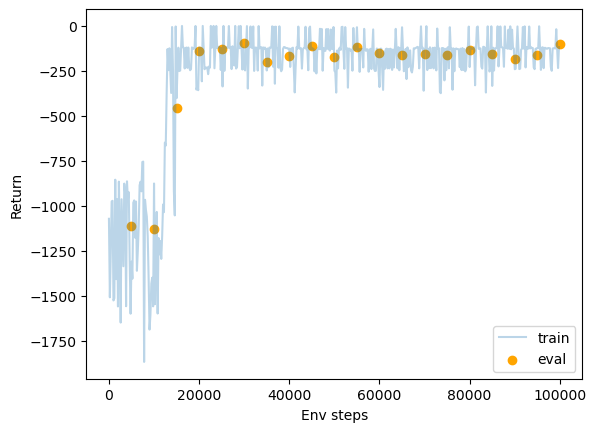

Final Eval over 100 episodes: -154.70


In [ ]:
EXPLORATION_STEPS = 10_000  # best from tuning

# Retraining with best hyperparameters
agent = train_sac(
    max_steps=100_000,            # longer training
    batch_size=512,
    gamma=0.997,
    tau=0.005,
    lr_p=0.0003,
    lr_q=0.0003,
    lr_a=0.0003,
    auto_entropy=AUTO_ENTROPY,
    hidden_dim=512,
    target_entropy=TARGET_ENTROPY
)

# Final evaluation
final_eval = assess_policy(agent, gym.make(ENV_NAME), episodes=100)
print(f"Final Eval over 100 episodes: {final_eval:.2f}")


In [ ]:
def train_sac(max_steps, batch_size, gamma, tau, lr_p, lr_q, lr_a,
              auto_entropy, hidden_dim, target_entropy,
              early_stop=True, patience=5, min_delta=1.0):
    
    env = gym.make(ENV_NAME)
    eval_env = gym.make(ENV_NAME)
    torch.manual_seed(0); np.random.seed(0); env.action_space.seed(0)

    agent  = SAC(OBS_SIZE, ACT_SIZE, ACT_LIMIT,
                 gamma, tau, lr_p, lr_q, lr_a, auto_entropy,
                 hidden_dim, target_entropy)
    buffer = ReplayBuffer(OBS_SIZE, ACT_SIZE)

    o, _    = env.reset(seed=0)
    train_rs, eval_rs, steps_ls = [], [], []
    ret, length = 0.0, 0

    best_eval = float('-inf')
    epochs_no_improve = 0

    for t in range(1, max_steps + 1):
        a = env.action_space.sample() if t <= EXPLORATION_STEPS else agent.select_action(o)
        a = np.clip(a, env.action_space.low, env.action_space.high)
        o2, r, term, trunc, _ = env.step(a)
        done = term or trunc
        buffer.add(o, a, o2, r, done)
        o, ret, length = o2, ret + r, length + 1

        if t > EXPLORATION_STEPS:
            agent.train(buffer, batch_size)

        if done:
            train_rs.append(ret)
            o, ret, length = env.reset()[0], 0.0, 0

        if t % EVAL_FREQ == 0:
            val = assess_policy(agent, eval_env, EVAL_EPISODES)
            eval_rs.append(val); steps_ls.append(t)
            print(f"Step {t}: EvalRet={val:.2f}")

            # early stopping
            if early_stop:
                if val > best_eval + min_delta:
                    best_eval = val
                    epochs_no_improve = 0
                    best_agent_state = agent.actor.state_dict()  # Save best model
                else:
                    epochs_no_improve += 1

                if epochs_no_improve >= patience:
                    print(f"Early stopping at step {t} — no improvement in {patience} evals.")
                    agent.actor.load_state_dict(best_agent_state)  # Roll back to best model
                    break

    # plotting
    def smooth(y, weight=0.9):
        smoothed = []
        last = y[0]
        for point in y:
            smoothed_val = last * weight + (1 - weight) * point
            smoothed.append(smoothed_val)
            last = smoothed_val
        return smoothed

    plt.figure(figsize=(10, 5))
    plt.plot(smooth(train_rs), label='Train Return (smoothed)', alpha=0.8)
    plt.scatter(steps_ls, eval_rs, color='orange', label='Eval Return')
    plt.xlabel('Episodes')
    plt.ylabel('Return')
    plt.legend()
    plt.grid(True)
    plt.title('SAC with Early Stopping')
    plt.tight_layout()
    plt.show()

    return agent, train_rs, eval_rs, steps_ls


Step 5000: EvalRet=-1158.62
Step 10000: EvalRet=-1123.73
Step 15000: EvalRet=-243.92
Step 20000: EvalRet=-107.15
Step 25000: EvalRet=-142.69
Step 30000: EvalRet=-156.88
Step 35000: EvalRet=-146.90
Step 40000: EvalRet=-75.82
Step 45000: EvalRet=-135.46
Step 50000: EvalRet=-128.79
Step 55000: EvalRet=-132.46
Step 60000: EvalRet=-197.81
Early stopping at step 60000 — no improvement in 4 evals.


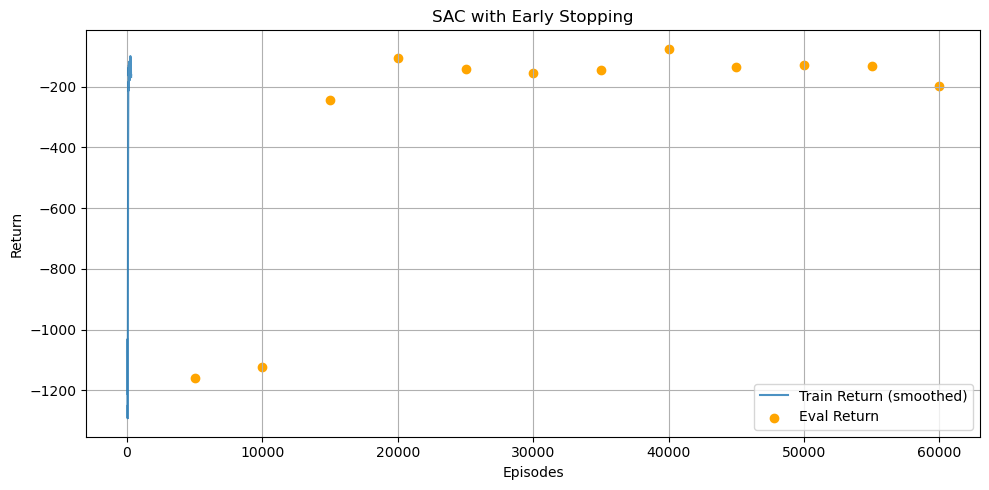

In [20]:
agent, train_returns, eval_returns, steps = train_sac(
    max_steps=100_000,
    batch_size=512,
    gamma=0.997,
    tau=0.005,
    lr_p=0.0003,
    lr_q=0.0003,
    lr_a=0.0003,
    auto_entropy=AUTO_ENTROPY,
    hidden_dim=512,
    target_entropy=TARGET_ENTROPY,
    early_stop=True,
    patience=4,        
    min_delta=0.5      # needs to improve by at least 0.5 to count
)


In [23]:
train_steps = [i * 200 for i in range(len(train_returns))]


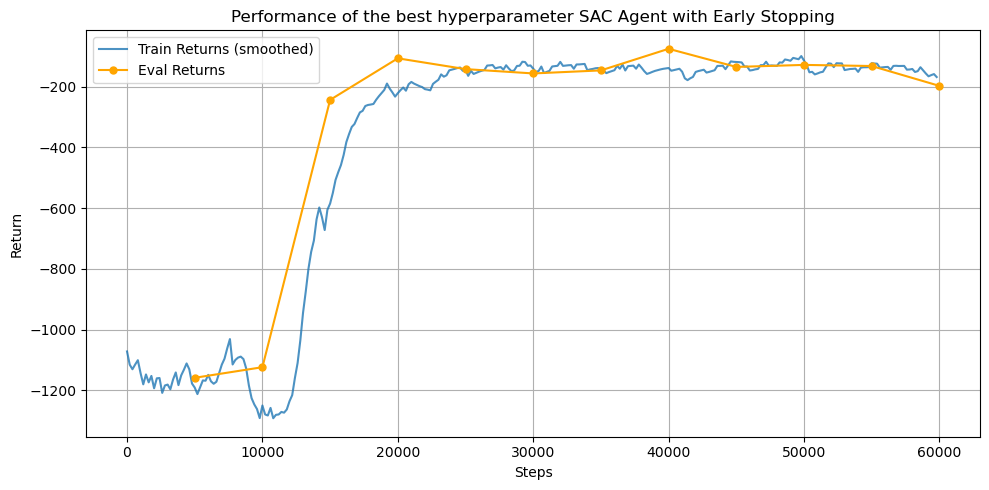

In [25]:
plt.figure(figsize=(10, 5))

# Plot smoothed training returns with proper x-axis
def smooth(y, weight=0.9):
    smoothed = []
    last = y[0]
    for point in y:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

plt.plot(train_steps, smooth(train_returns), label='Train Returns (smoothed)', alpha=0.8)

# Plot evaluation returns
plt.plot(steps, eval_returns, 'o-', label='Eval Returns', markersize=5, color='orange')

plt.xlabel('Steps')
plt.ylabel('Return')
plt.title('Performance of the best hyperparameter SAC Agent with Early Stopping')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
